In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Apply Clustering in a brutal way

So far, the clustering using few variables of interest have not been successful. In this notebook, we aim to apply clustering algorithm in a more brutal-force approach, using mainly the 32 samples (standardised + brought to 0).

We also apply beforehand some cuts very efficient in signal.

Here are the ground rules:
- no amplitude variables are used
- the distributions are standardised and the zero is brought to the mean or pedestal

## Libraries

In [2]:
import itertools
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from lib import plot as lp, rootdata as lrd, data, clustering

from project import defs, files, col, normalize
from project.defs import dict_color_clu_labels
from project import compute_chi2
import data_cuts

import hdbscan


## Load ROOT file

In [4]:
config_name = "run1_layer0_only_lowchi2"
file_path = files.get_path_processed_root(config_name)

In [5]:
list_voi = [
    'pos_max', #'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
]

columns = [
    'max_m_mean',
    'min_std_pos_neg',
    'min_std_pos_neg_redpn',
    'max_m_mean_red',
]

other_columns = [
    "pos_first_neg_after_max",
    "nb_peaks_sup_80_wrt_min",
    "best_chi2"
]

dataframe, column_labels = files.load_and_process_dataframe(
    file_path, list_voi, columns, other_columns,
    branches=defs.list_samples_columns+["eta", "phi", "region", "detector"],
    verbose=True
)

DeserializationError: while reading

    TBasket version None as uproot.models.TBasket.Model_TBasket (? bytes)
        fNbytes: 69
        fObjlen: 0
        fDatime: 1828377883
        fKeylen: 69
        fCycle: 0
        fVersion: 3
        fBufferSize: 32000
        fNevBufSize: 8
        fNevBuf: 0
        fLast: 69
Members for TBasket: fNbytes?, fObjlen?, fDatime?, fKeylen?, fCycle?, fVersion?, fBufferSize?, fNevBufSize?, fNevBuf?, fLast?

attempting to get bytes 656977:656977
outside expected range 656839:656908 for this Chunk
in file /mnt/d/900GeV/processed/simulation/run1_layer0_only_lowchi2.root

In [5]:
dataframe = dataframe.query("std!=0")

In [6]:
column_labels_computed  = col.get_formula_labels(
    columns, column_labels
)

column_labels = {**column_labels, **column_labels_computed}

### Cuts

In [7]:
data_cuts.apply_signal_cuts(dataframe)

Cut pos_first_neg_after_max!=-1 -> efficiency 0.0
Cut min_std_pos_neg_redpn > 0.02 -> efficiency 0.0
Cut nb_peaks_sup_80_wrt_min == 1 -> efficiency 0.0
Cut pos_max <= 20 -> efficiency 0.0


### Plots

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\eta$', ylabel='$\\phi$'>)

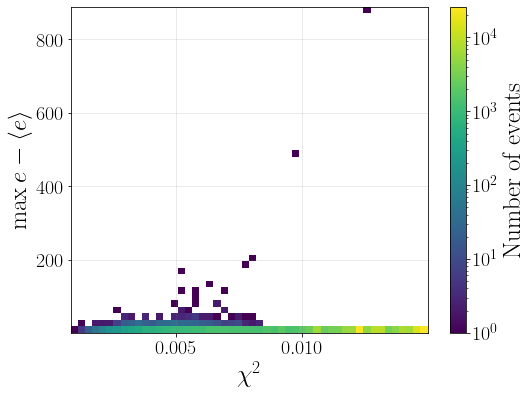

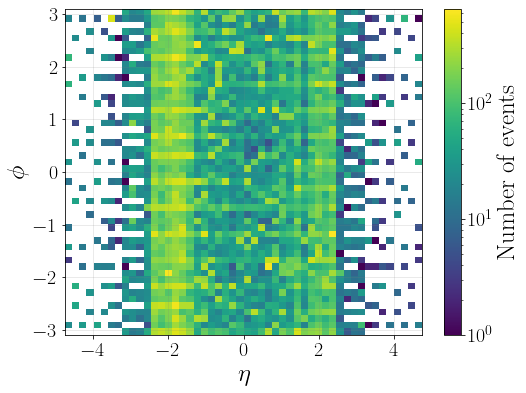

In [8]:
lp.plot_hist2d(
    dataframe["best_chi2"], dataframe["max_m_mean"],
    column_labels["best_chi2"], column_labels["max_m_mean"],
    logscale=True
)

lp.plot_hist2d(
    dataframe["eta"], dataframe["phi"],
    column_labels["eta"], column_labels["phi"],
    logscale=True
)


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Detector', ylabel='Number of events'>)

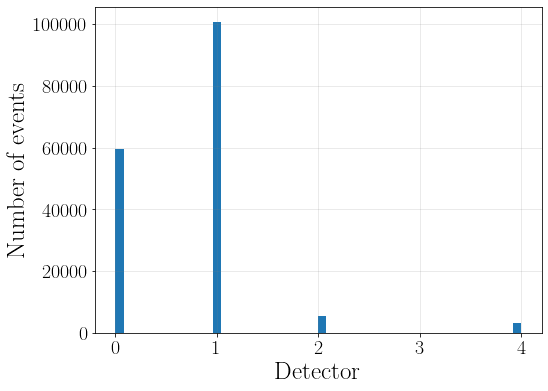

In [9]:
lp.plot_hist(dataframe["detector"], "Detector")

{'eta_phi': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x864 with 8 Axes>)}

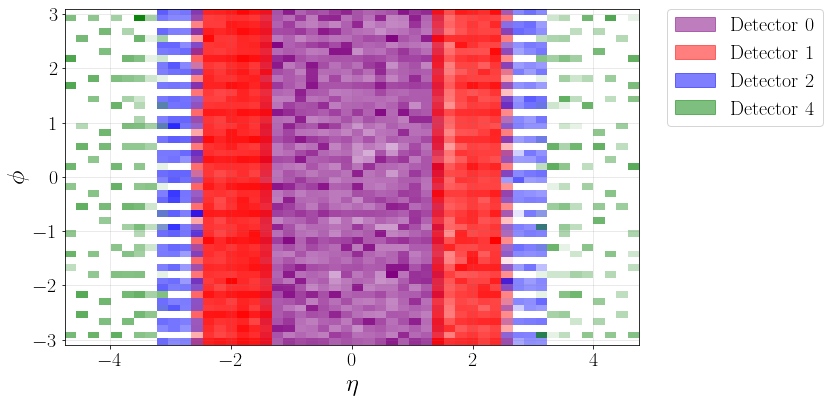

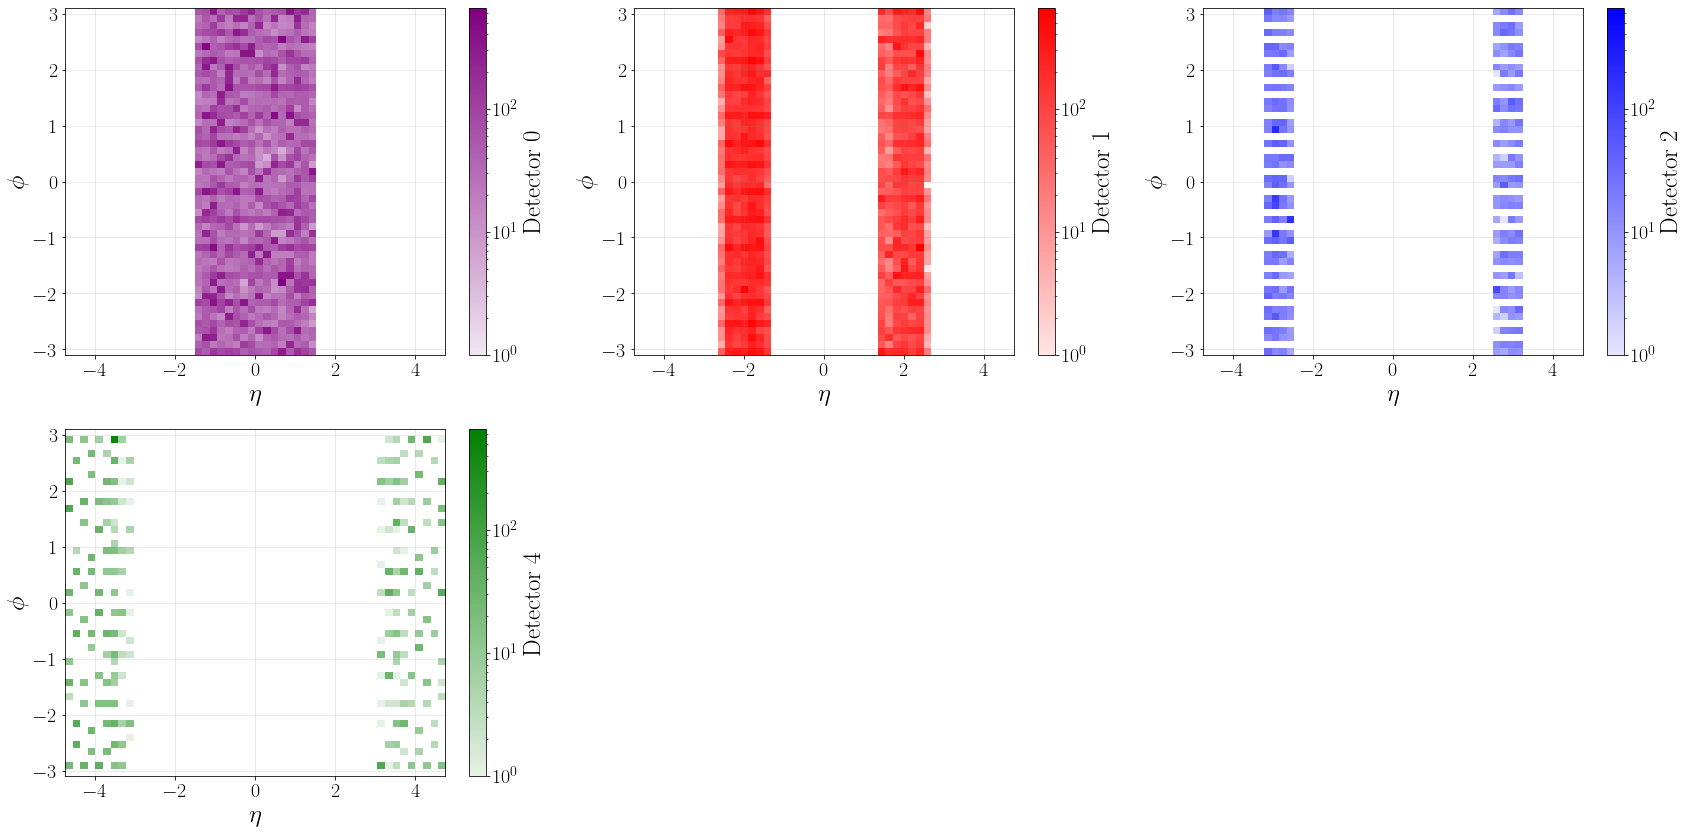

In [15]:
clustering.plot_clusters_hist2d(
    dataframe, 
    ['eta', "phi"],
    column_labels,
    "detector",
    logscale=True,
    dict_color_clu_cats=defs.dict_color_clu_labels,
    category_name="Detector"
)

{'eta_phi': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x1296 with 14 Axes>)}

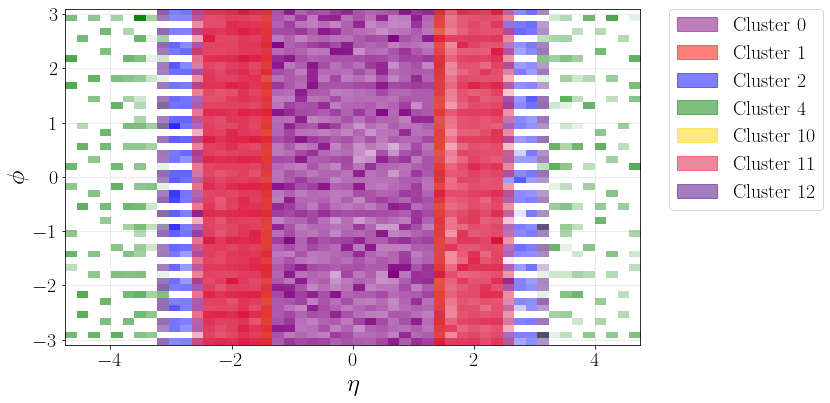

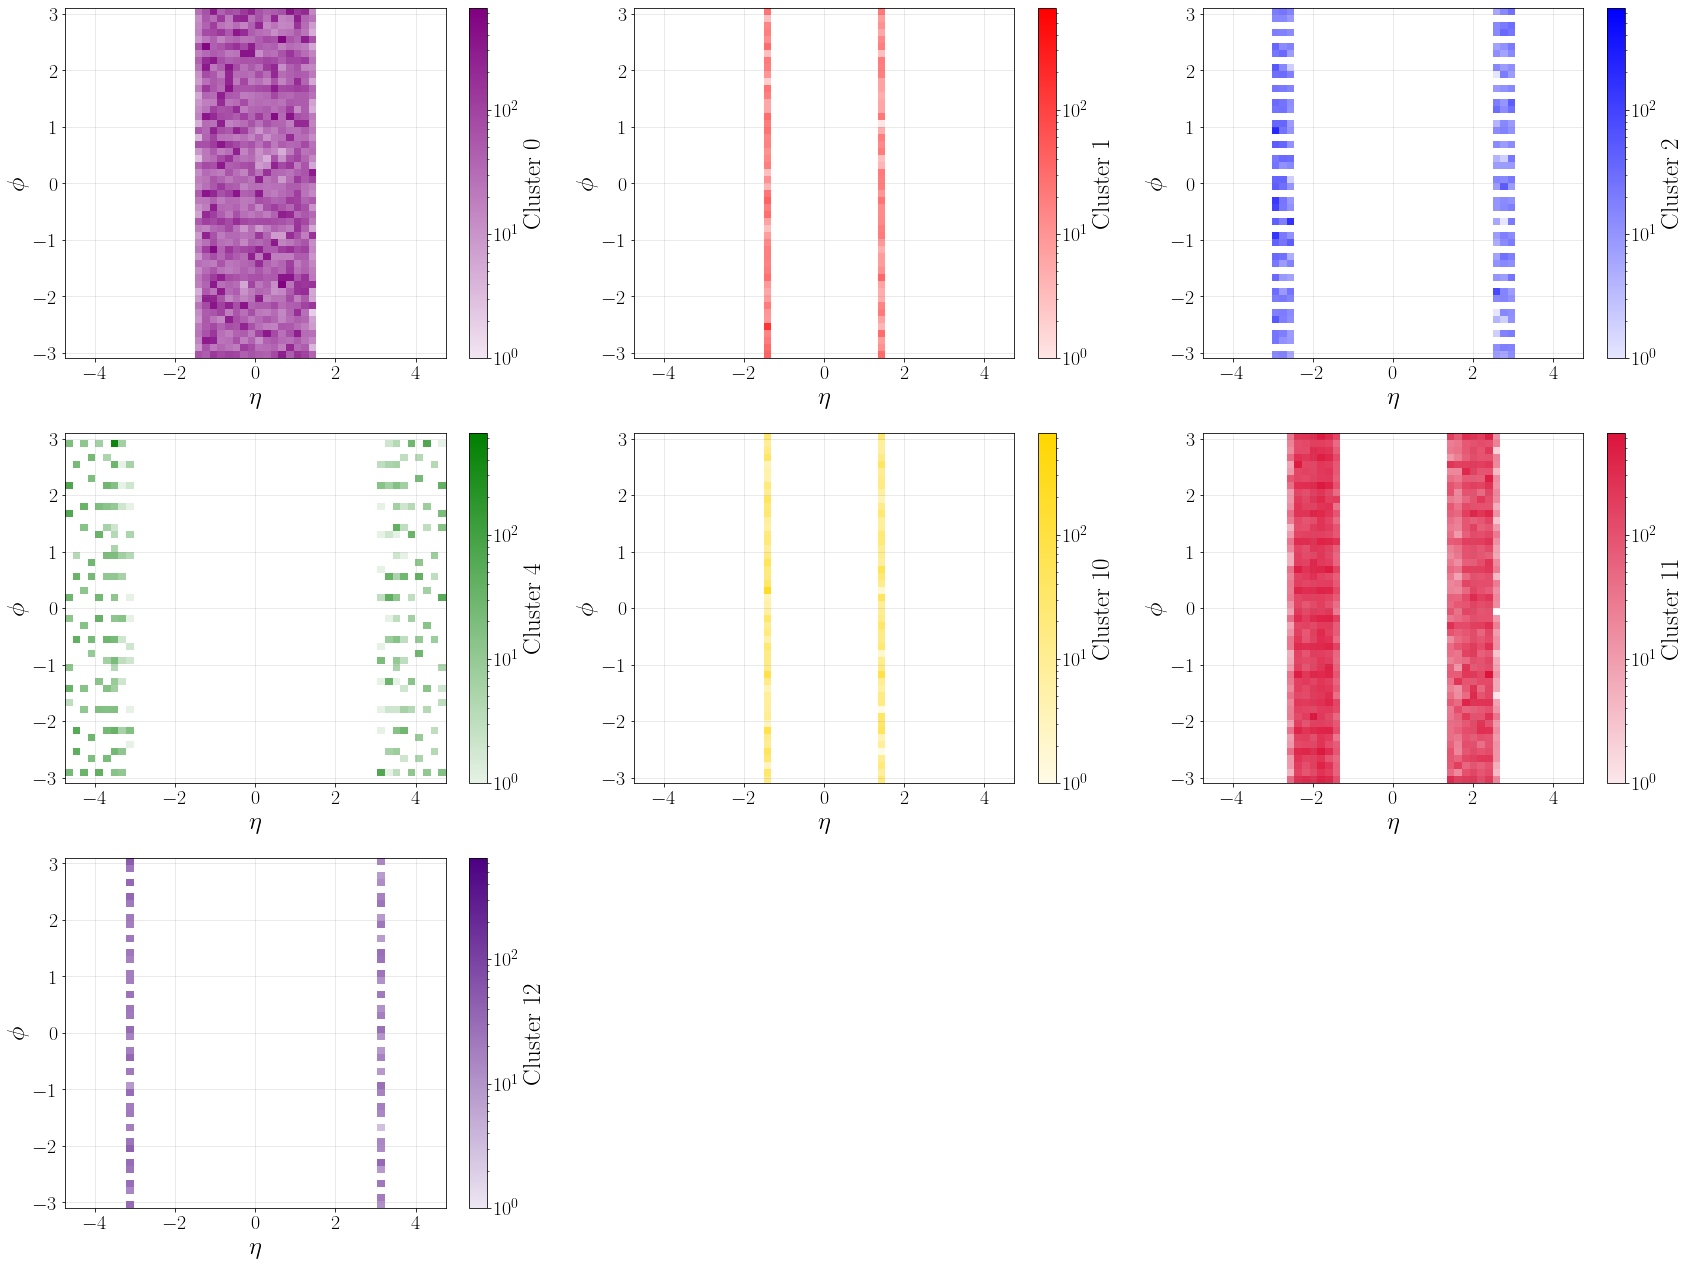

In [11]:
dataframe["detector_region"] = dataframe["detector"] + 10 * dataframe["region"]
clustering.plot_clusters_hist2d(
    dataframe, 
    ['eta', "phi"],
    column_labels,
    "detector_region",
    logscale=True,
    dict_color_clu_cats=defs.dict_color_clu_labels,
    # category_name="Detector"
)

## DBSCAN

In [12]:
features = defs.list_samples_columns

features_plot = [
    "best_chi2",
]

### Prepare dataframe

In [1]:
randomise_discretisation_clu = False

In [14]:
# dataframe_1 = dataframe.query("detector==4")
dataframe_1 = dataframe.query("max - min > 3")
len(dataframe_1)

41101

In [14]:
clustering_dataframe = deepcopy(dataframe_1)
if randomise_discretisation_clu:
    files.randomise_discretisation(clustering_dataframe)

clustering_dataframe[defs.list_samples_columns] -= np.round(
    data.get_1D_to_2D(clustering_dataframe["mean"])
)
clustering_dataframe[defs.list_samples_columns] /= data.get_1D_to_2D(
    clustering_dataframe["max"] - np.round(clustering_dataframe["mean"])
)

normalize.get_dataframe_pos_max_lined_up(
    clustering_dataframe
)

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time increment', ylabel='Output'>)

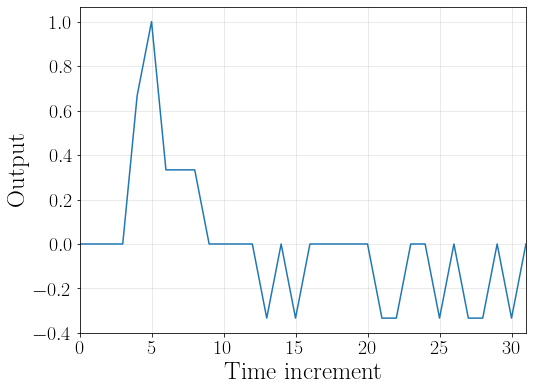

In [90]:
lp.plot_event(dataframe.iloc[6])

### Clustering

In [15]:
clu_label_name = "HDBSCAN"
clu_label_alias = "HDBSCAN"

In [16]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10, min_samples=1, 
    # cluster_selection_epsilon=2.
)
clusterer.fit(clustering_dataframe[features])

HDBSCAN(min_cluster_size=10, min_samples=1)

In [17]:
dataframe_1[clu_label_name] = clusterer.labels_

/tmp/ipykernel_12623/3914033727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_1[clu_label_name] = clusterer.labels_


The resulting dataframe is saved.

In [18]:
# import uproot4
# from lib.utils import try_makedirs

# output_path = op.join(defs.proc_folder, "clustering")
# full_output_path = op.join(output_path, 
#     f"{config_name}_{clu_label_name}.root")
# try_makedirs(output_path)
# out_file = uproot4.recreate(full_output_path)
# out_file[defs.proc_tree_name] = dataframe

In [19]:
np.unique(dataframe_1[clu_label_name])

array([-1,  0,  1,  2,  3,  4,  5,  6])

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='HDBSCAN', ylabel='Number of events'>)

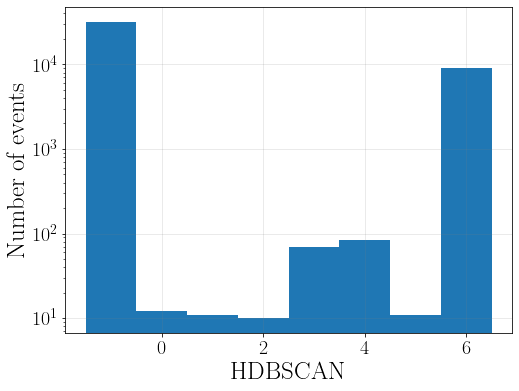

In [41]:
bins = clustering.get_edges_from_clust_labels(
    clusterer.labels_
)

lp.plot_hist(
    dataframe_1[clu_label_name],
    clu_label_alias,
    logscale=True,
    bins=bins,
)

### How clusters are arranged w.r.t. detector

In [21]:
bins

array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5])

In [22]:
bins

array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5])

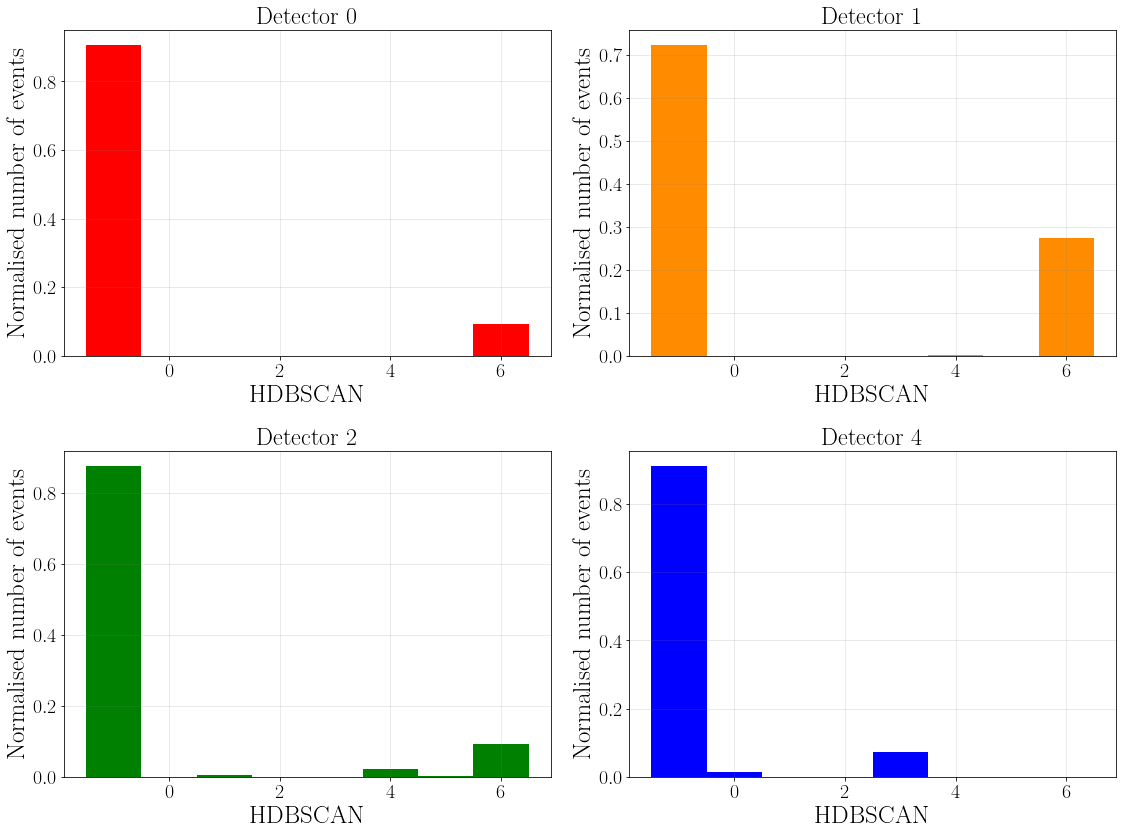

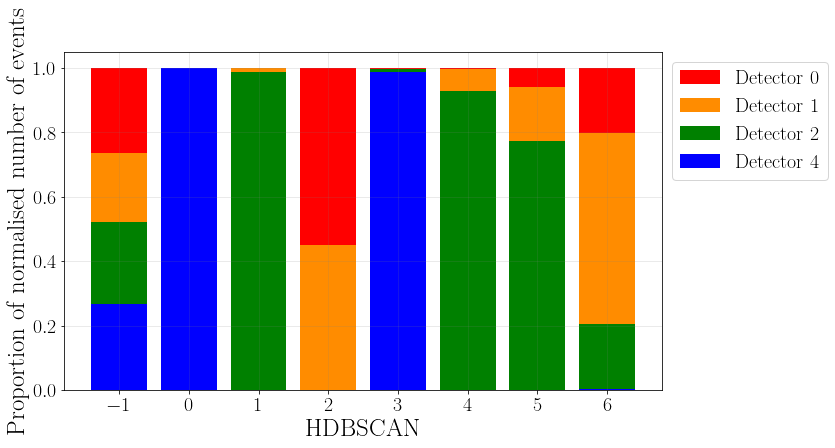

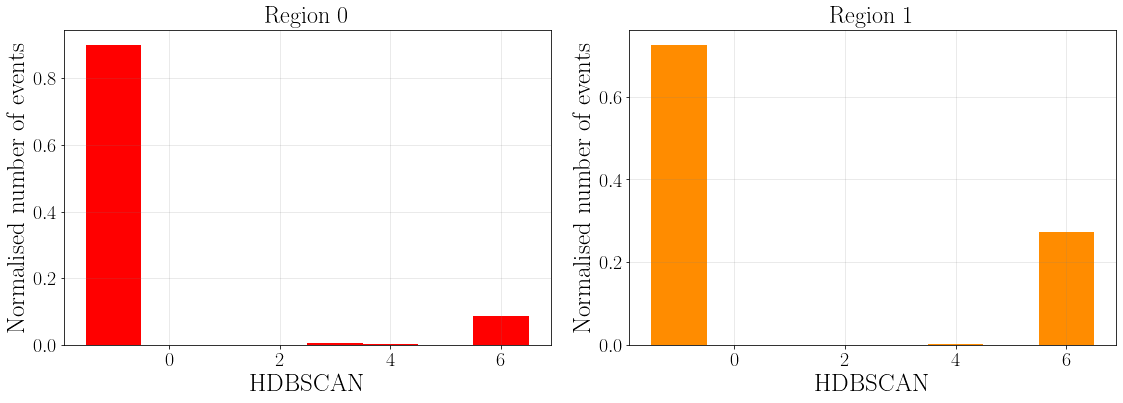

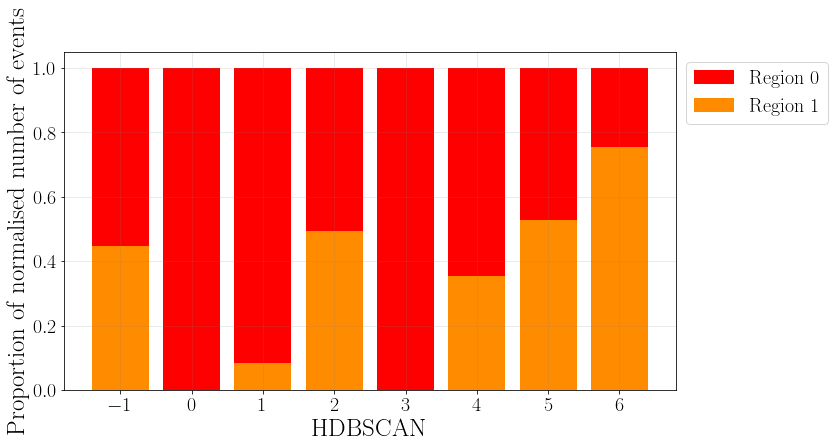

In [118]:
detector_values = np.unique(dataframe_1["detector"])
atlas_columns = ["detector", "region"]

atlas_column_values = {}
atlas_column_name = {}
for column in atlas_columns:
    atlas_column_values[column] = np.unique(dataframe_1[column])
    atlas_column_name[column] = column.capitalize()

for column in ["detector", "region"]:
    for method in ["multi_ax", "one_ax_stacked_norm"]:
        lp.multi_plot_hist_same_col(
            [dataframe_1.query(f"{column}=={col_val}") for col_val in atlas_column_values[column]],
            clu_label_name,
            clu_label_alias,
            [f"{atlas_column_name[column]} {col_val}" for col_val in atlas_column_values[column]],
            list_colors=["r", 'darkorange', 'green', 'blue'],
            bins=bins,
            method=method,
            bin_width_scale=0.8 if method == "one_ax_stacked_norm" else 1.,
            max_ncols=2,
        )

### Charactéristiques des clusters

{'eta_phi': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x1296 with 16 Axes>)}

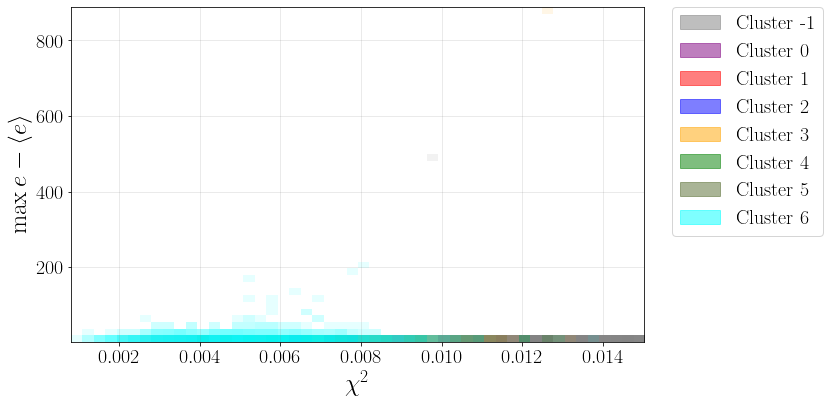

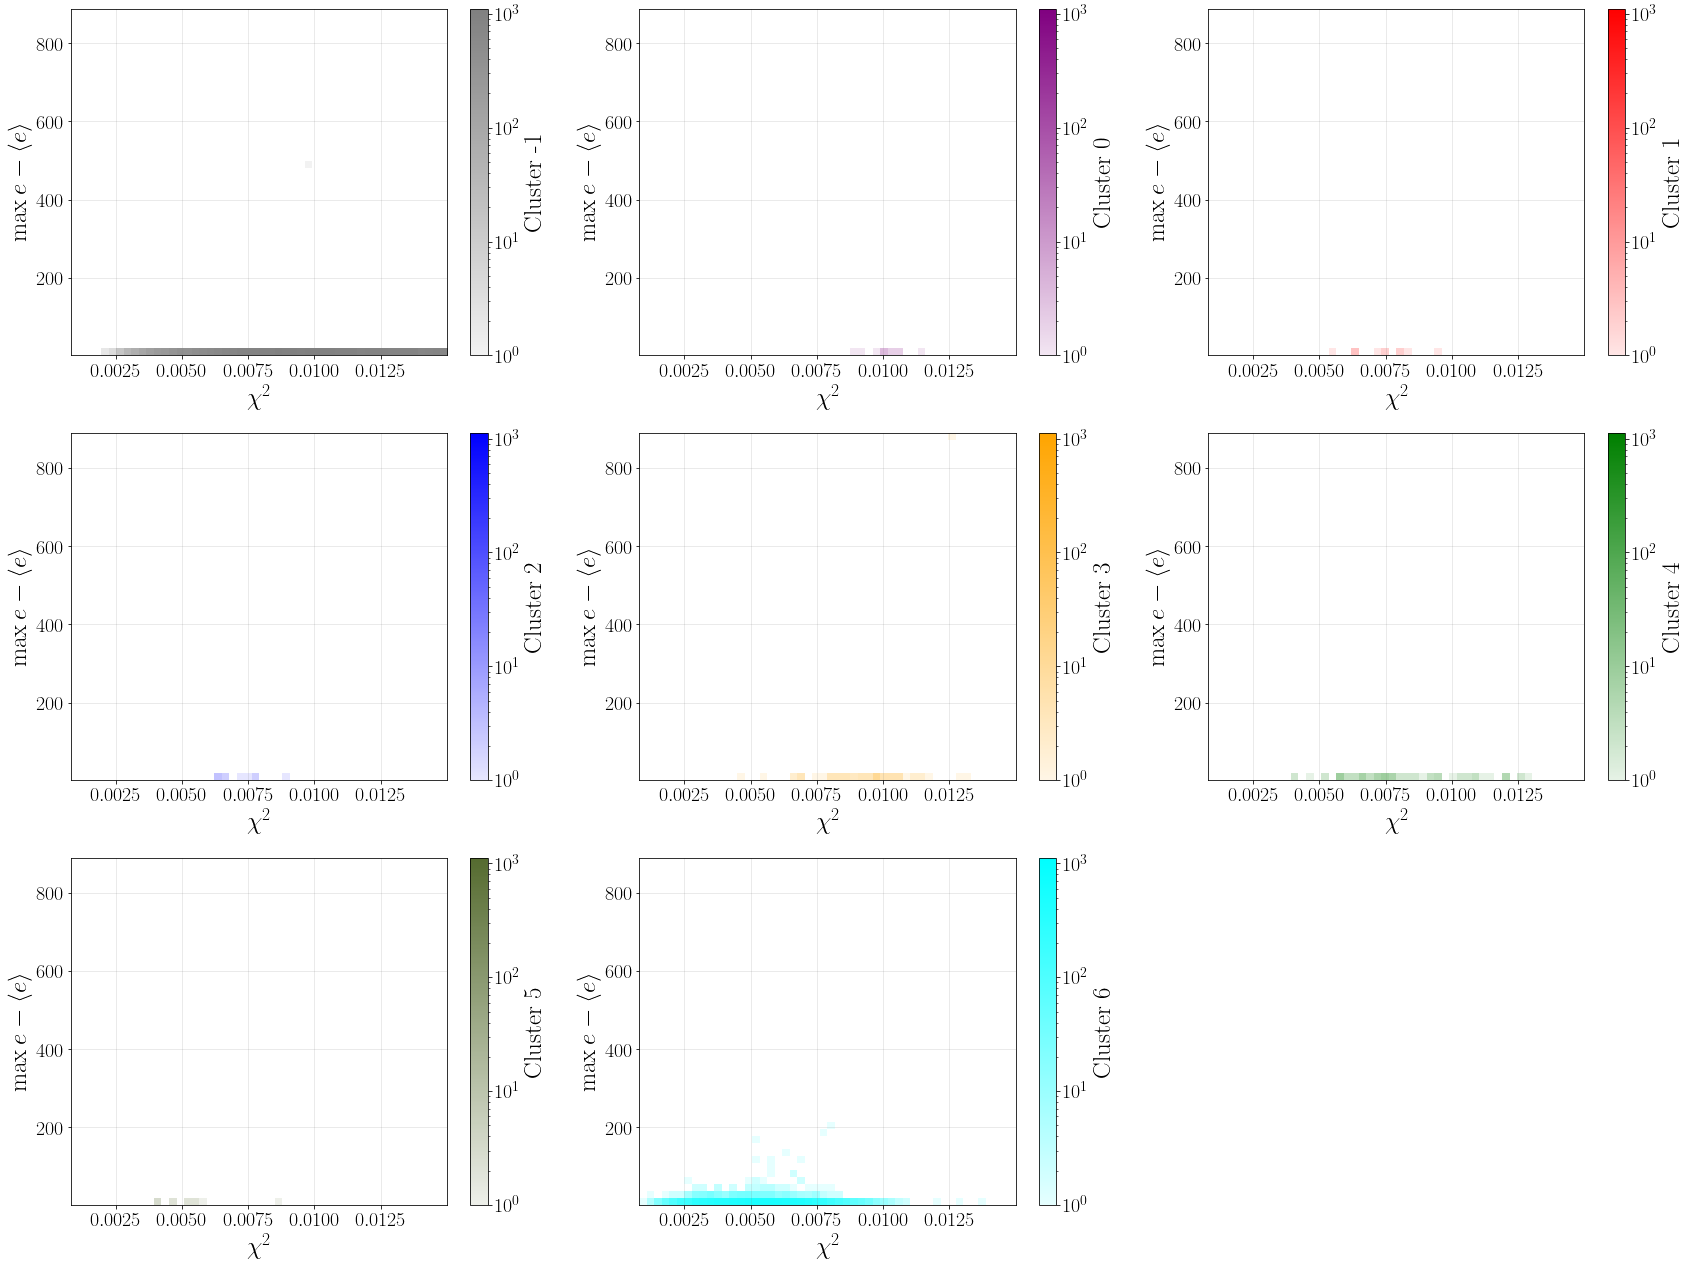

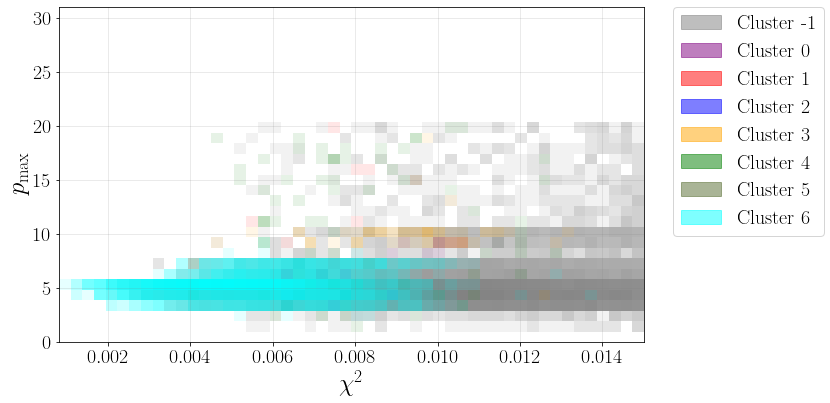

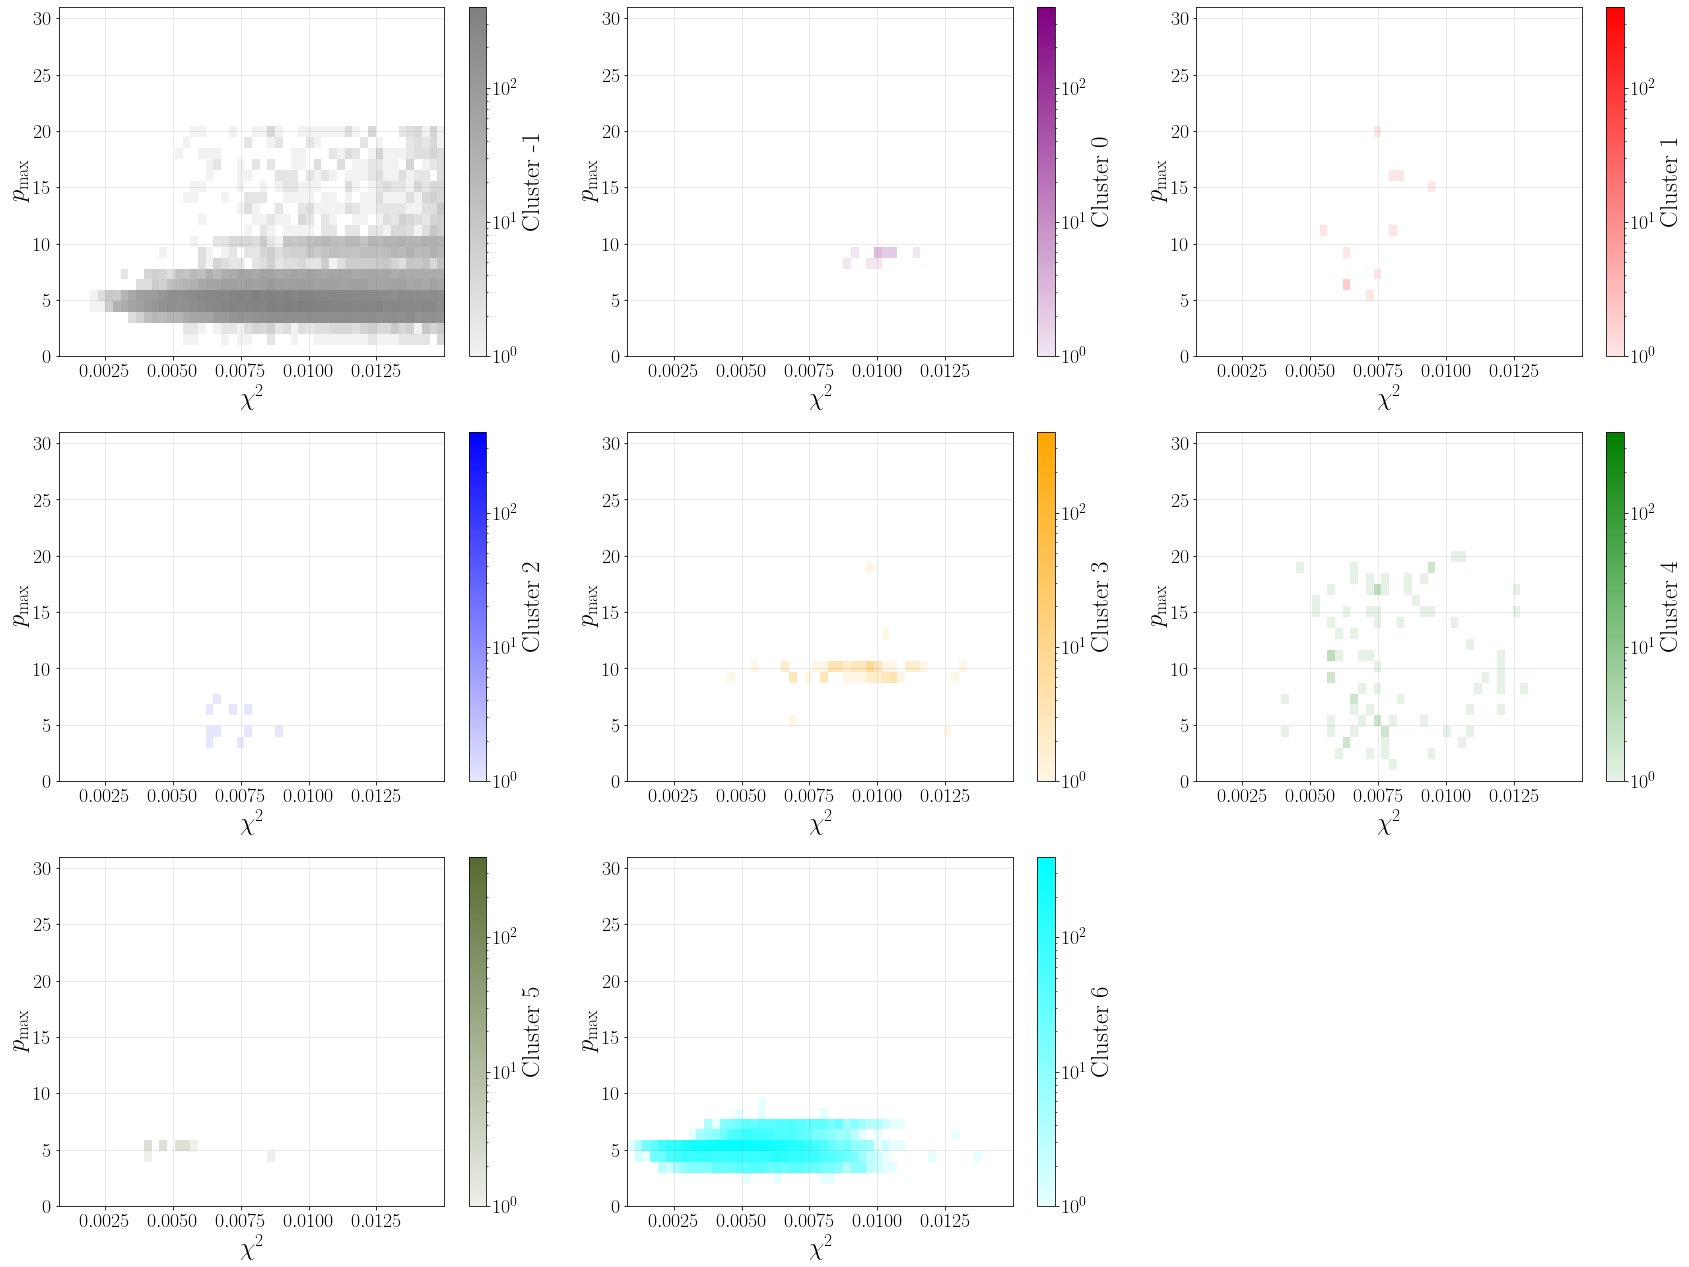

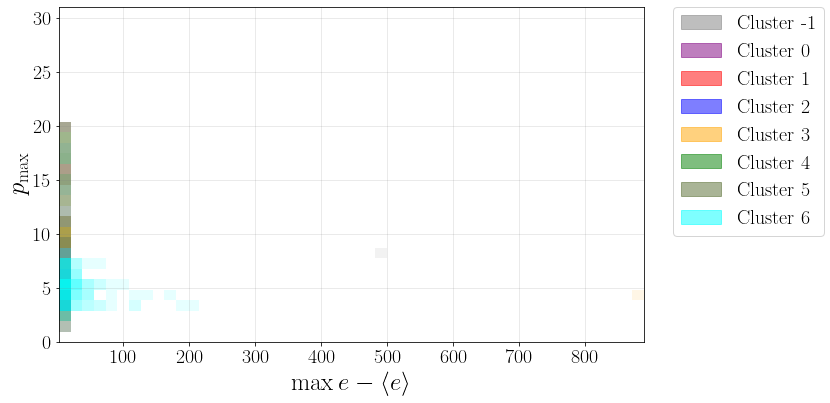

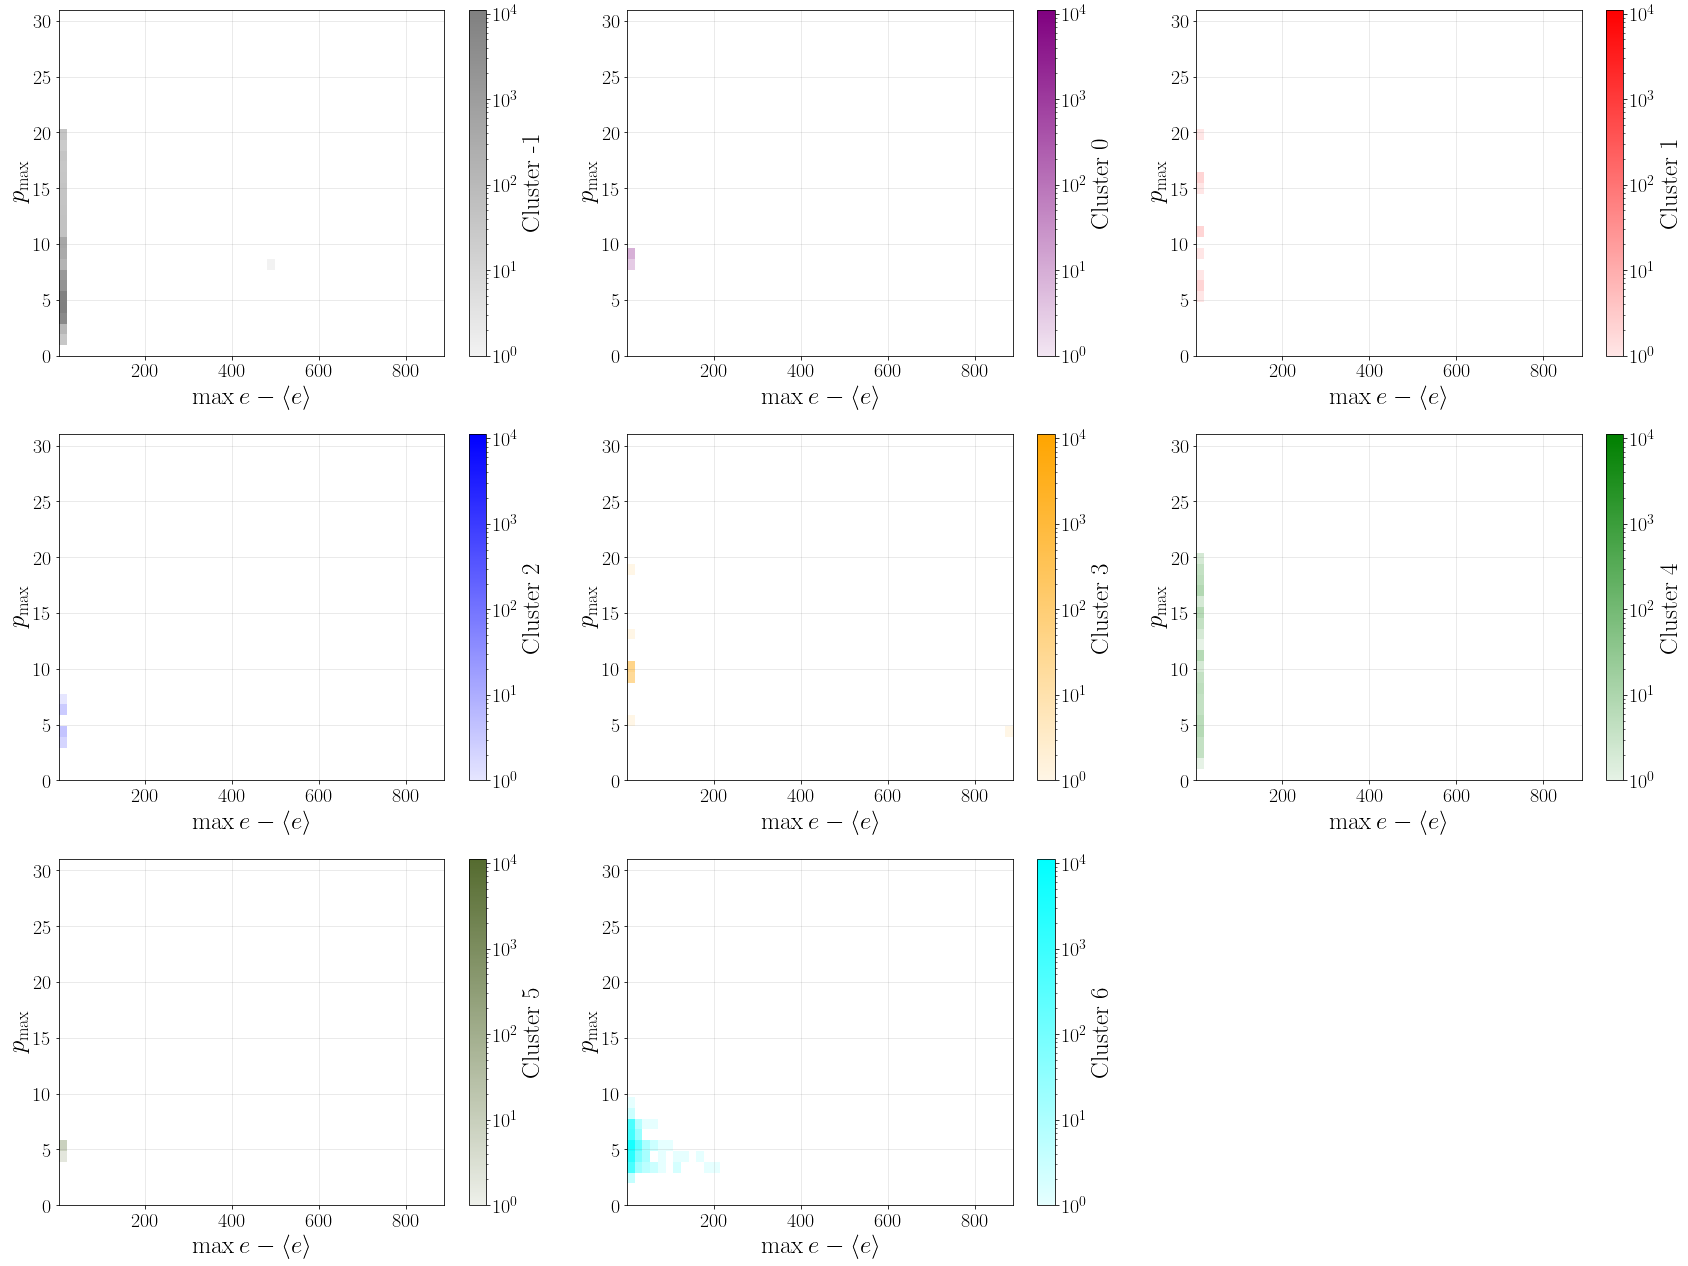

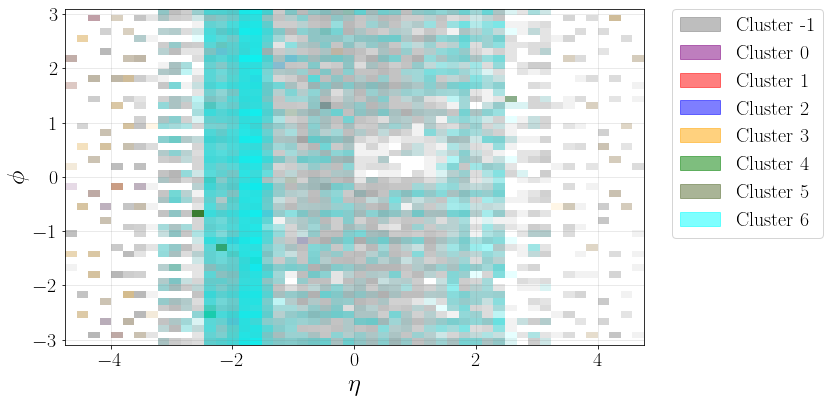

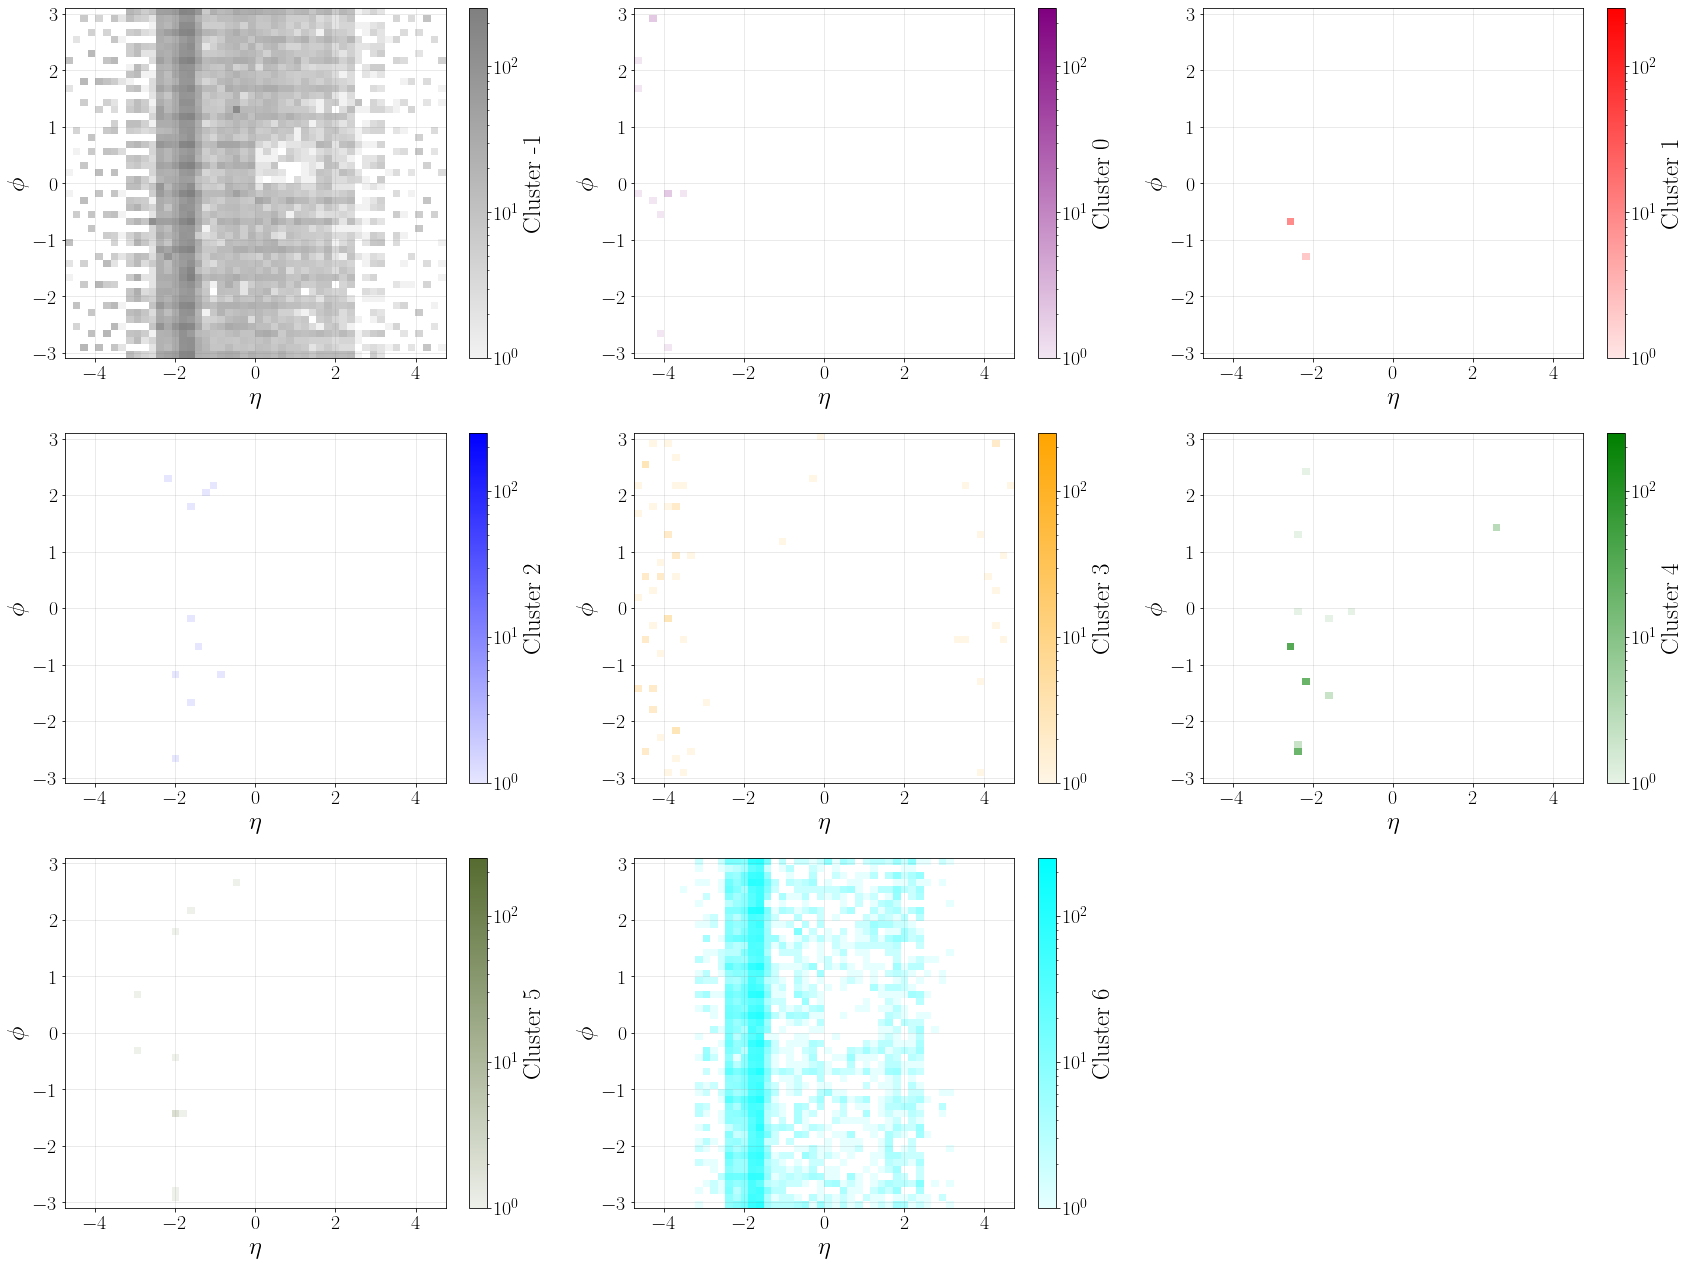

In [129]:
### Caractéristique des clusters
from project.defs_range import column_ranges, column_nbins
column_nbins["pos_max"] = 32

clustering.plot_clusters_hist2d(
    dataframe_1, 
    features_plot + ['max_m_mean', "pos_max"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=defs.dict_color_clu_labels,
    column_ranges=column_ranges,
    column_nbins=column_nbins
)


clustering.plot_clusters_hist2d(
    dataframe_1, 
    ['eta', "phi"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=defs.dict_color_clu_labels,
    column_ranges=column_ranges,
    column_nbins=column_nbins
)

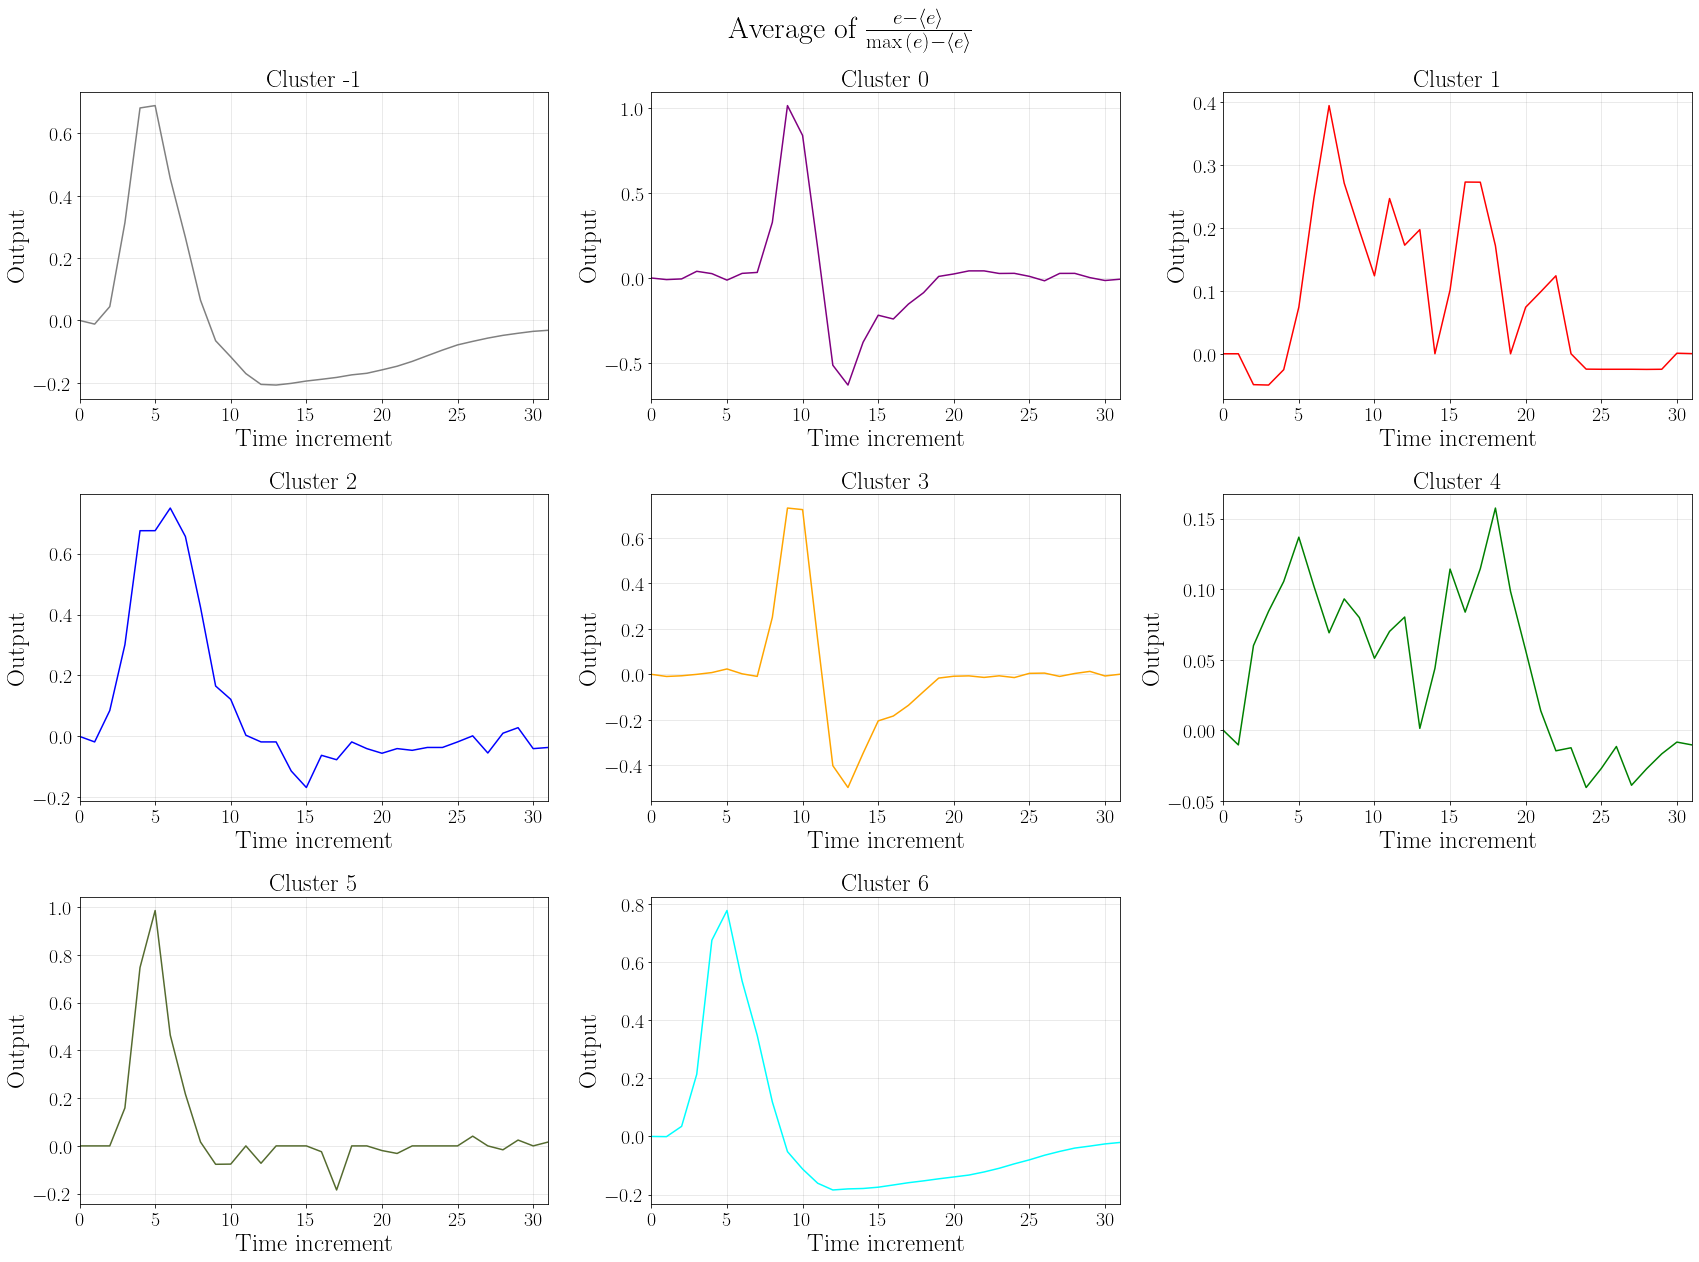

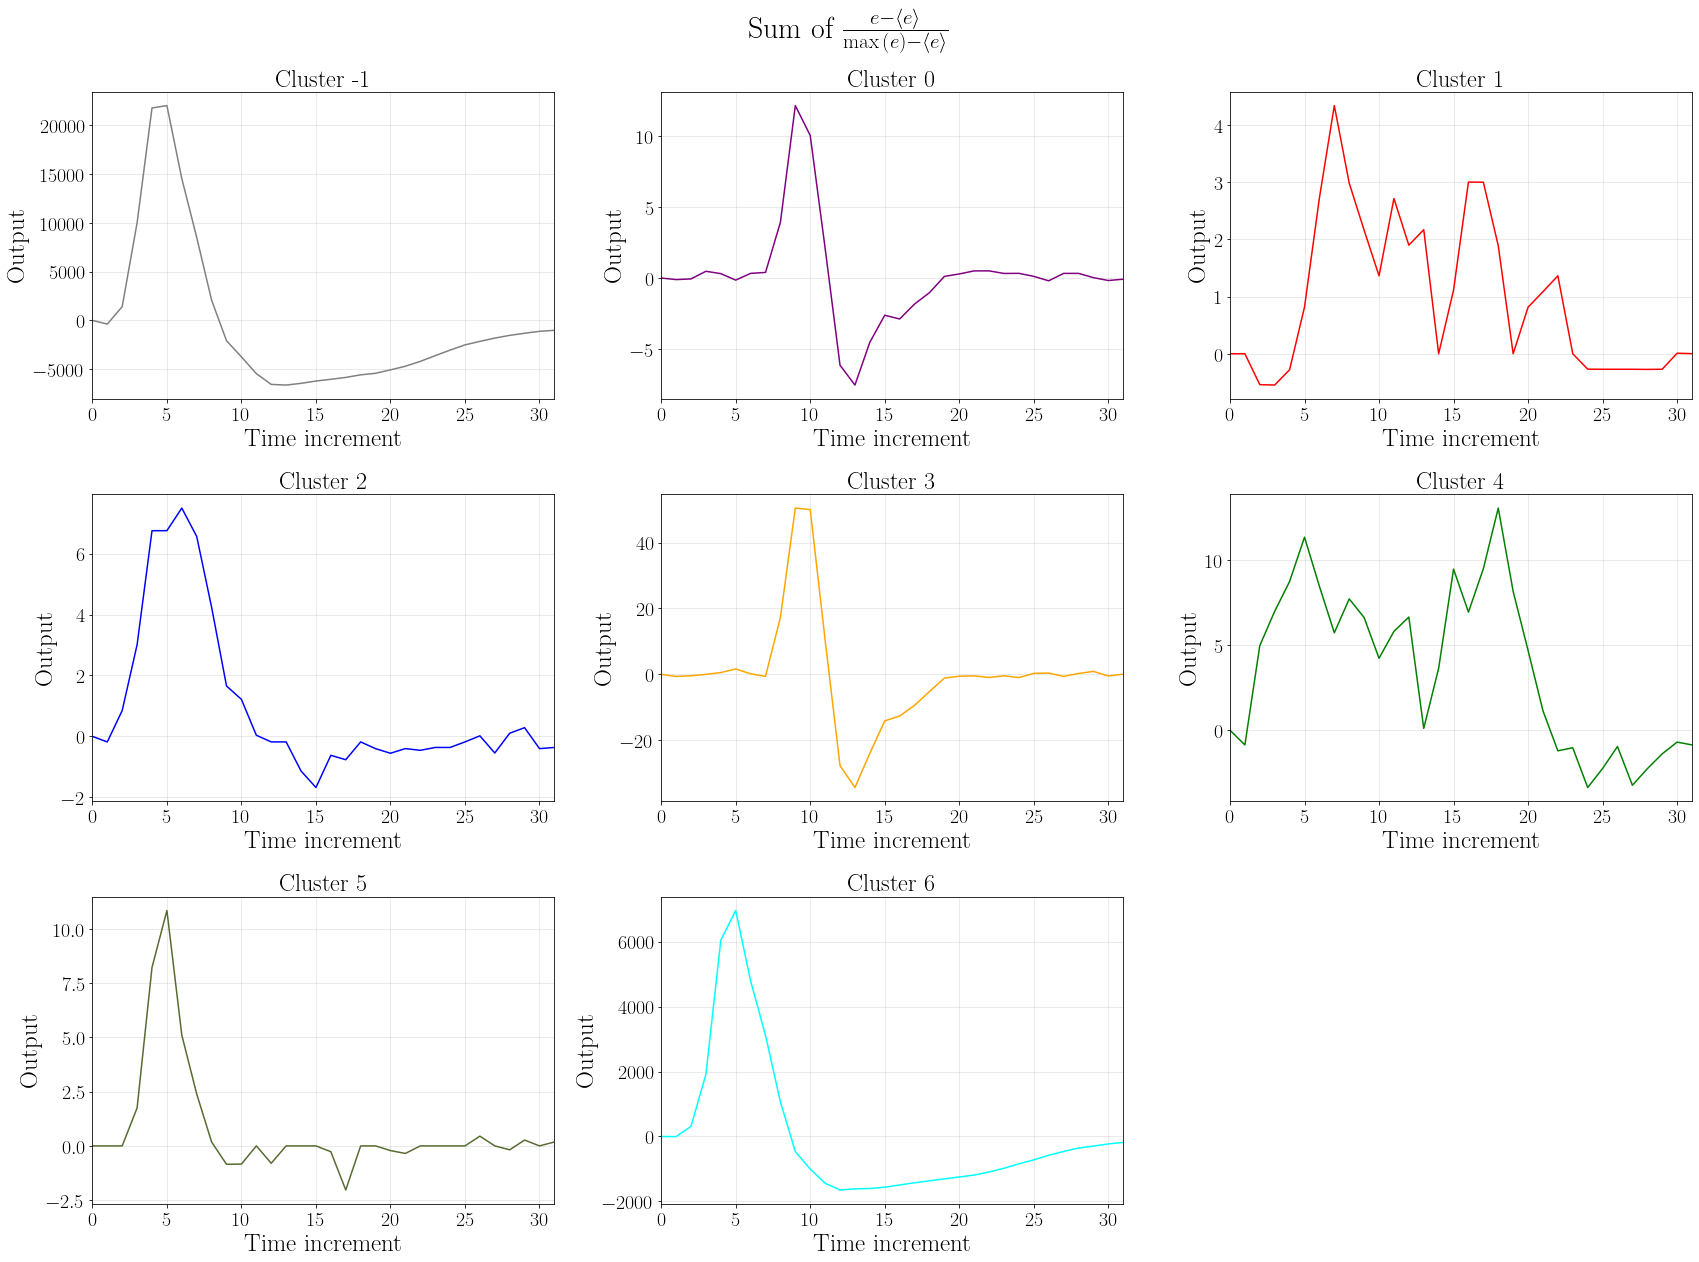

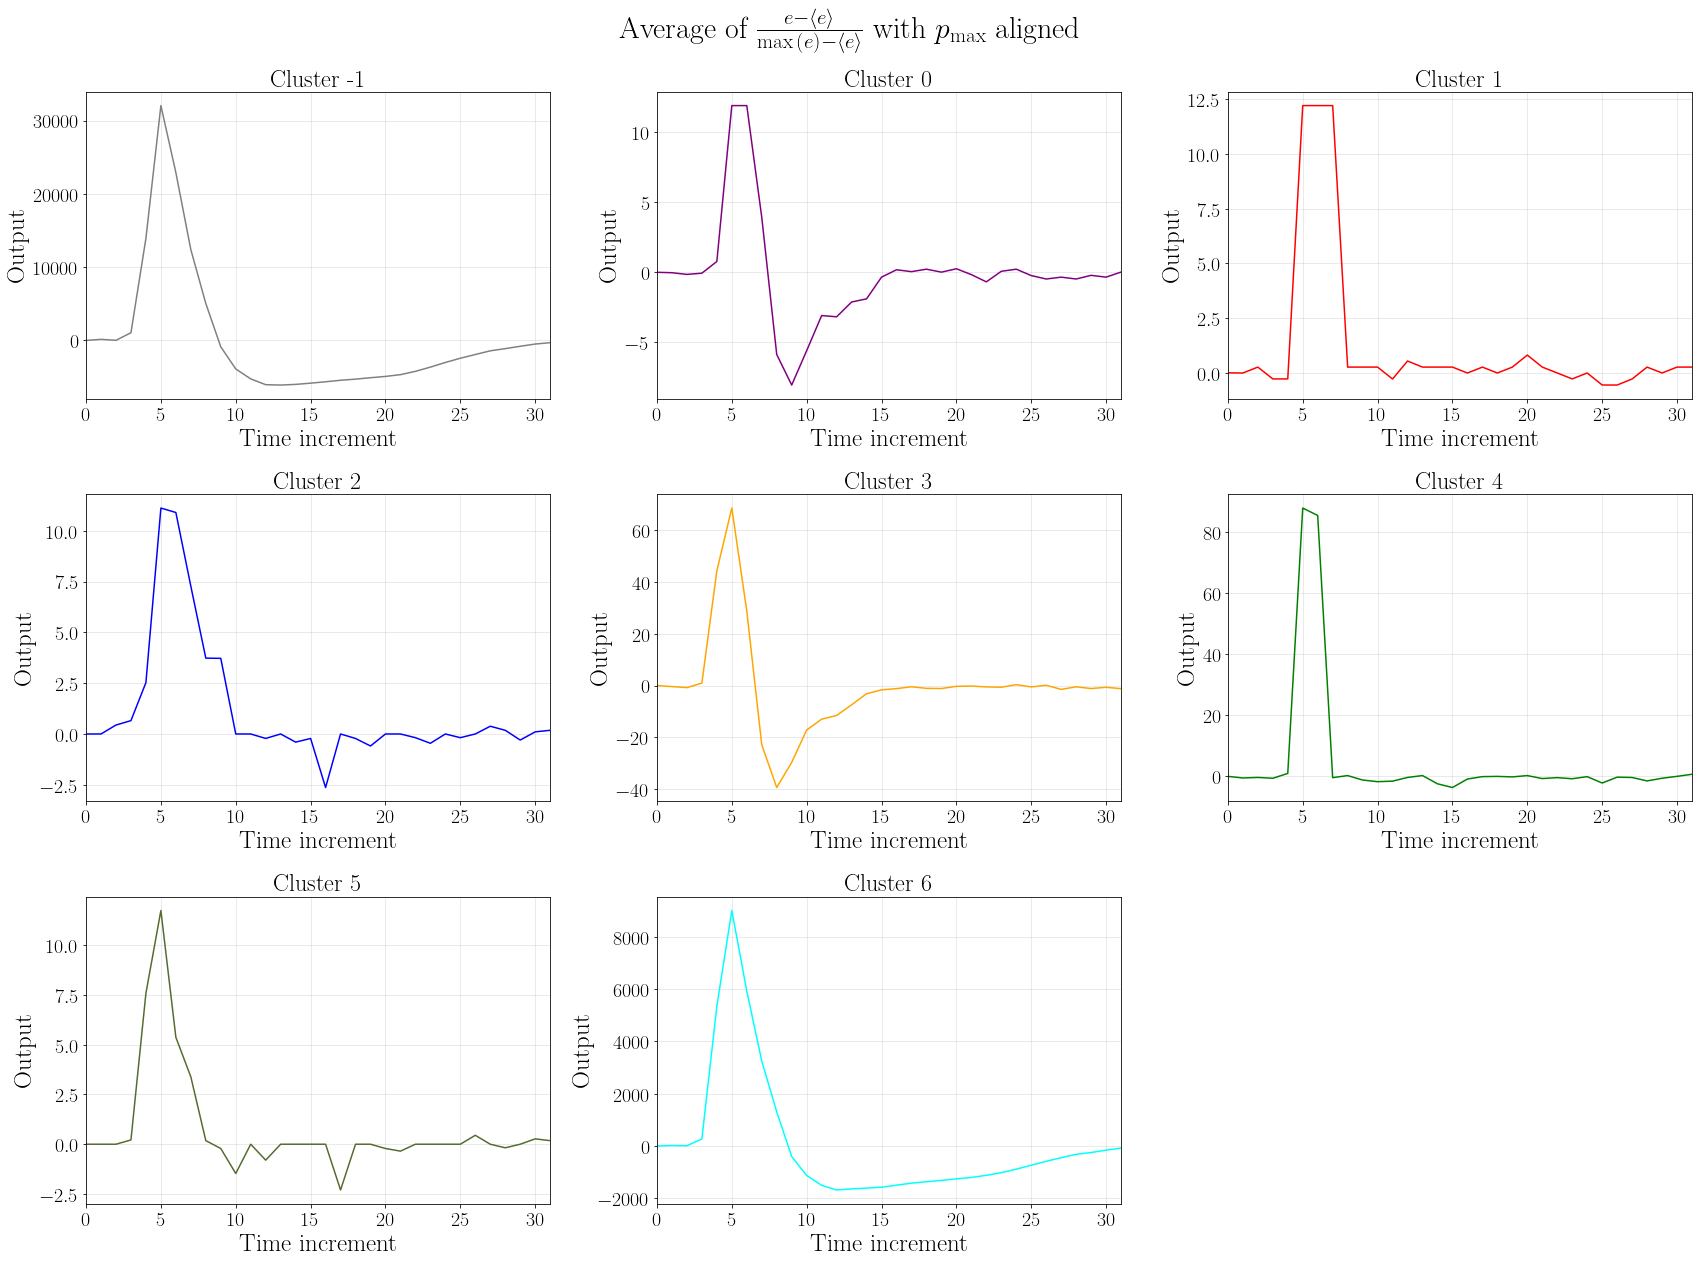

In [130]:
normalised_df = deepcopy(dataframe_1)
normalised_df[defs.list_samples_columns] -= data.get_1D_to_2D(normalised_df["mean"])
normalised_df[defs.list_samples_columns] /= data.get_1D_to_2D(normalised_df["max_m_mean"])

fig, _ = clustering.plot_samples_clusters(
    normalised_df,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="sum"
)

fig.suptitle(r"Sum of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)



fig, _ = clustering.plot_samples_clusters(
    normalize.get_dataframe_pos_max_lined_up(
            normalised_df, inplace=False
    ),
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="sum"
)

fig.suptitle(r"Average of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$ with $p_{\text{max}}$ aligned", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)

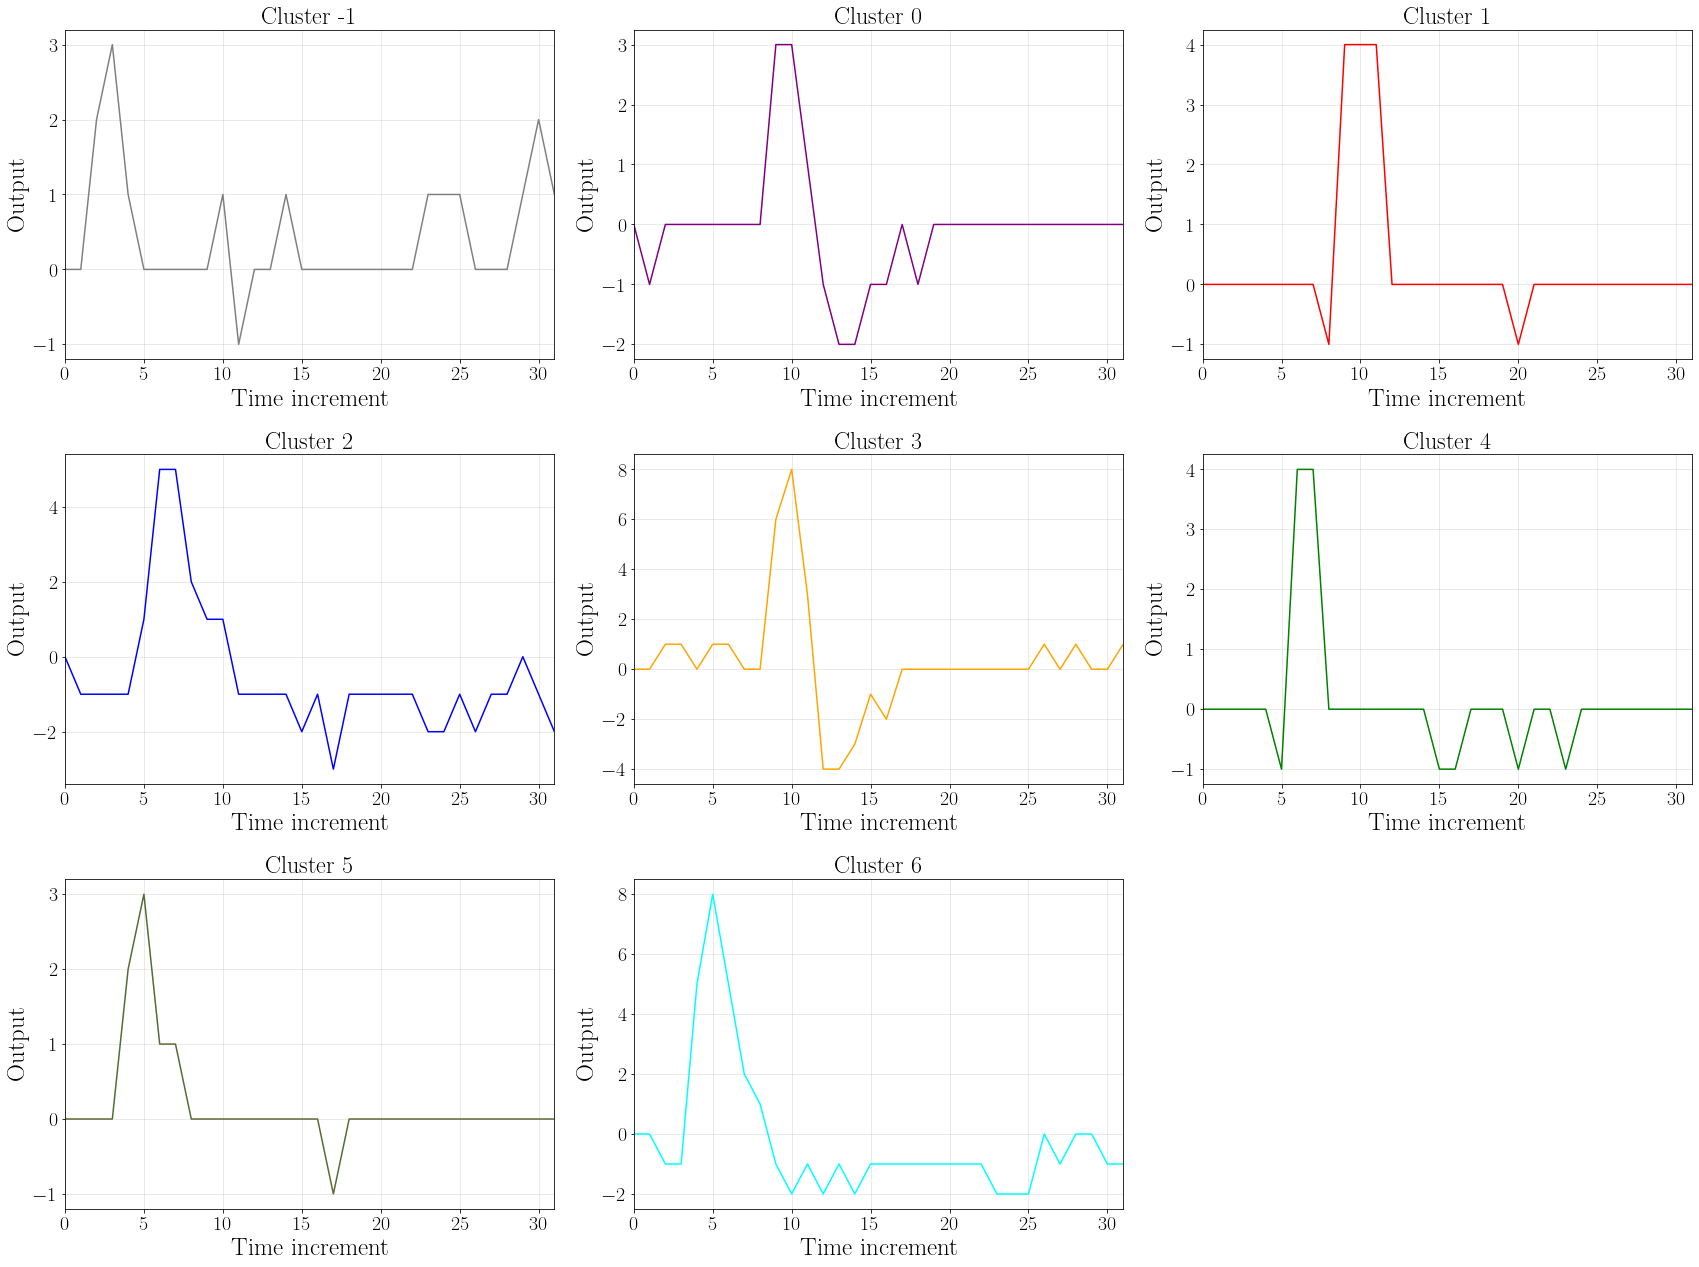

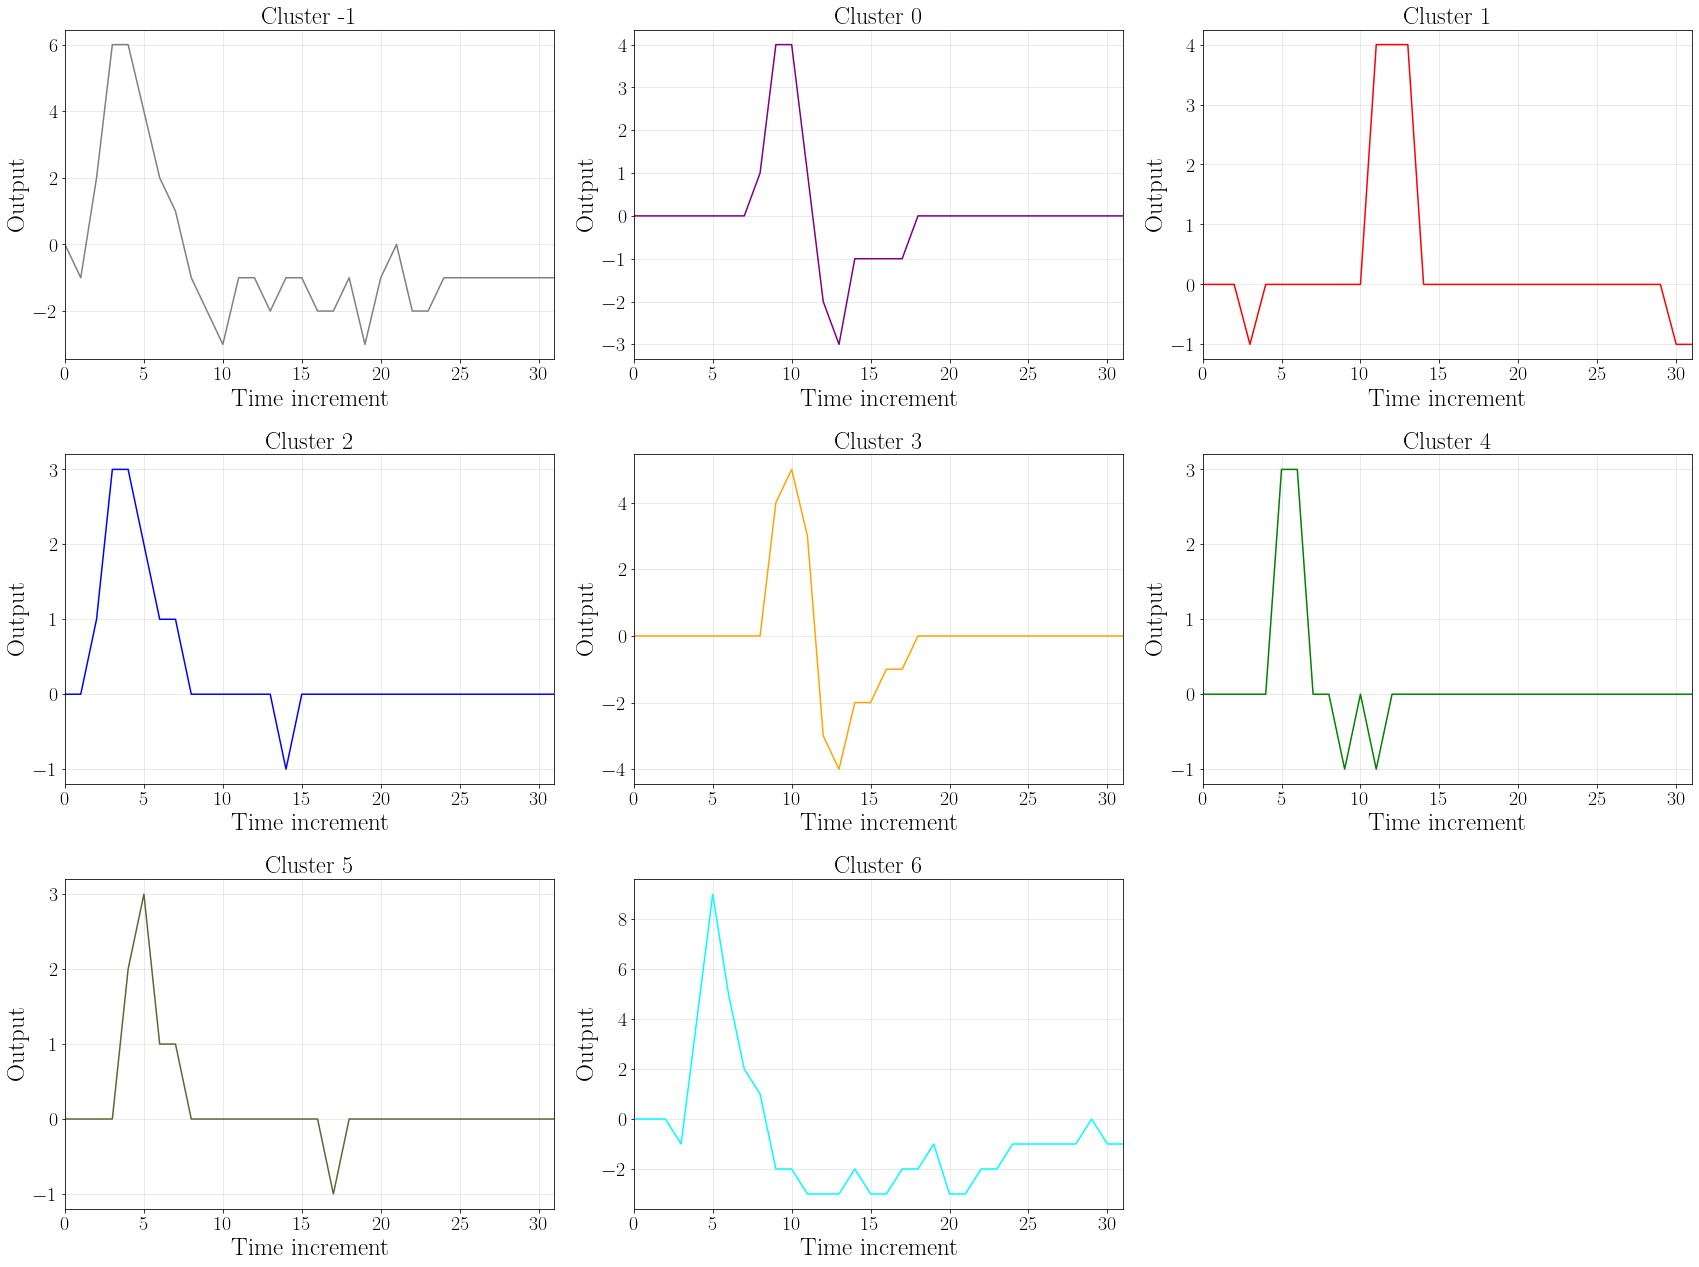

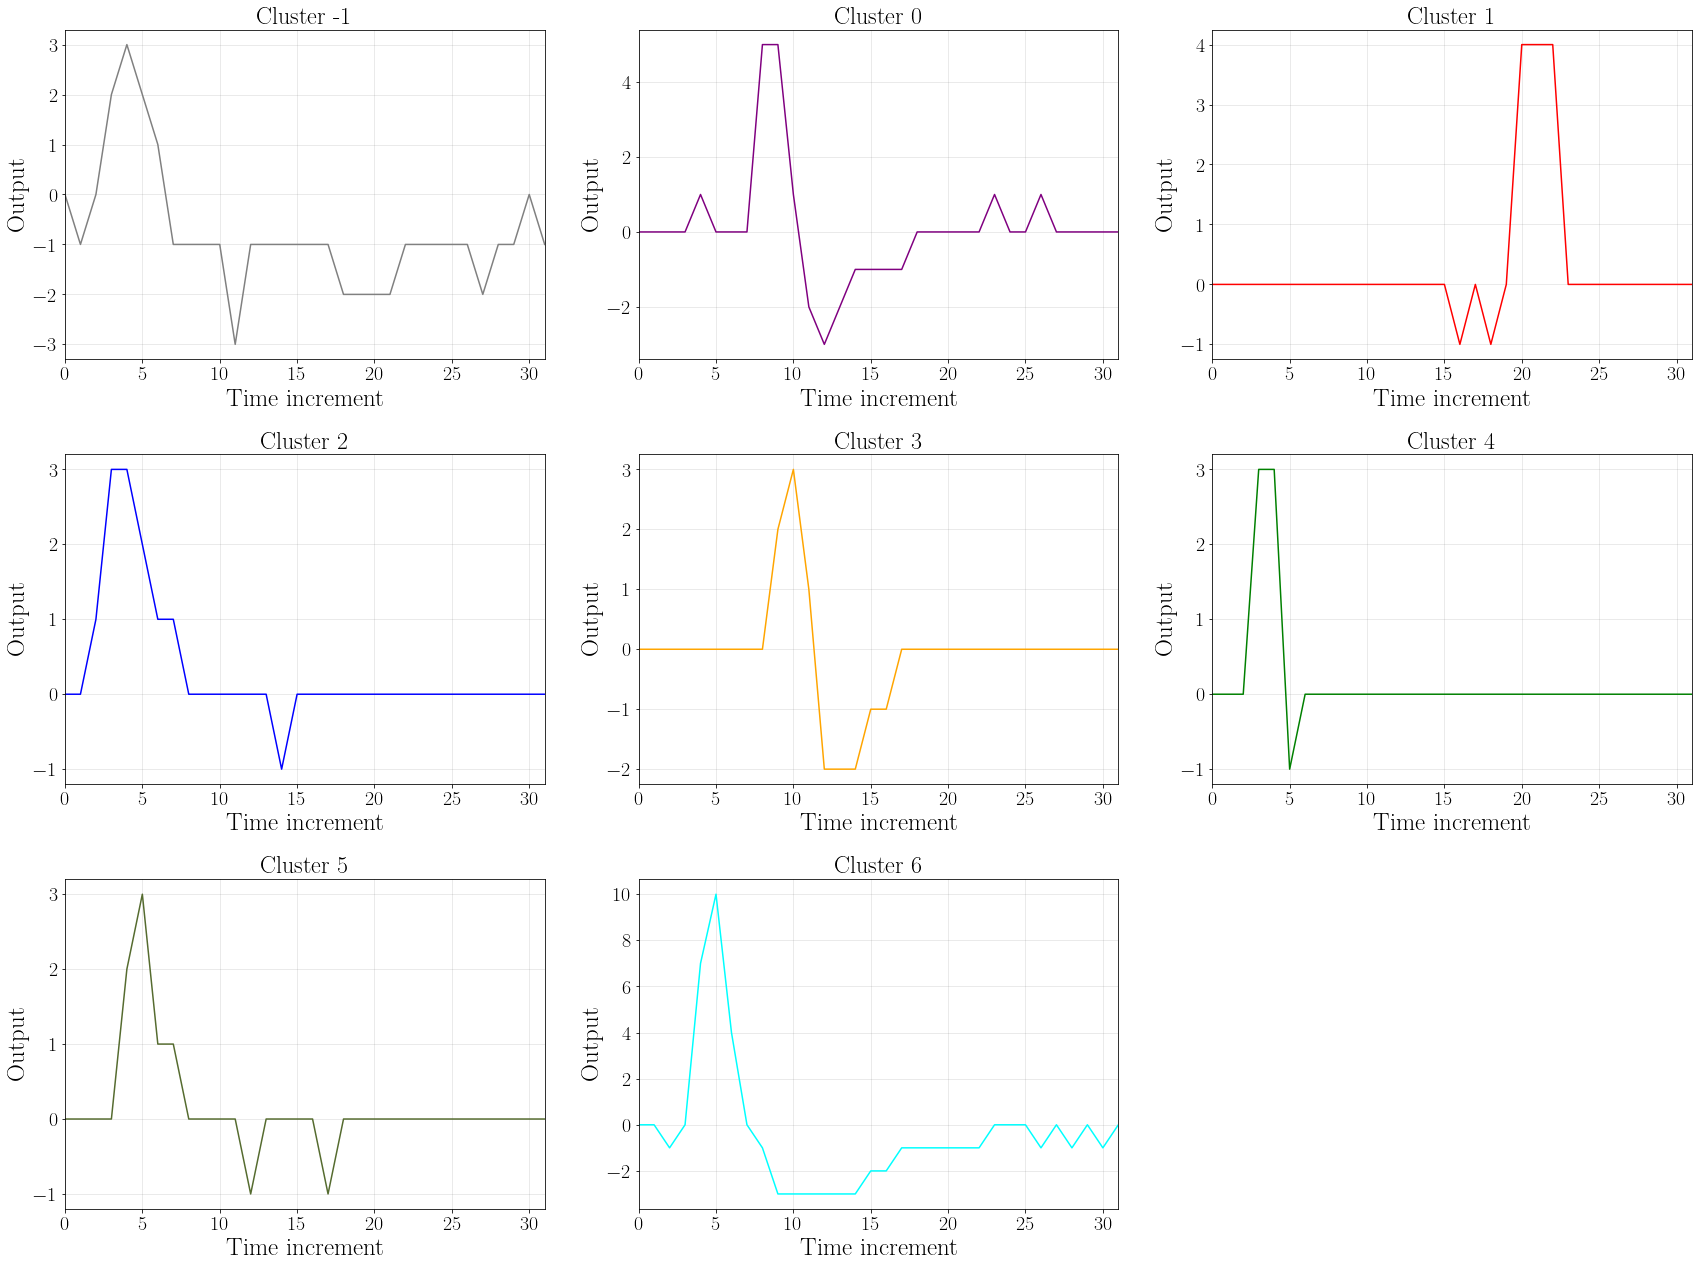

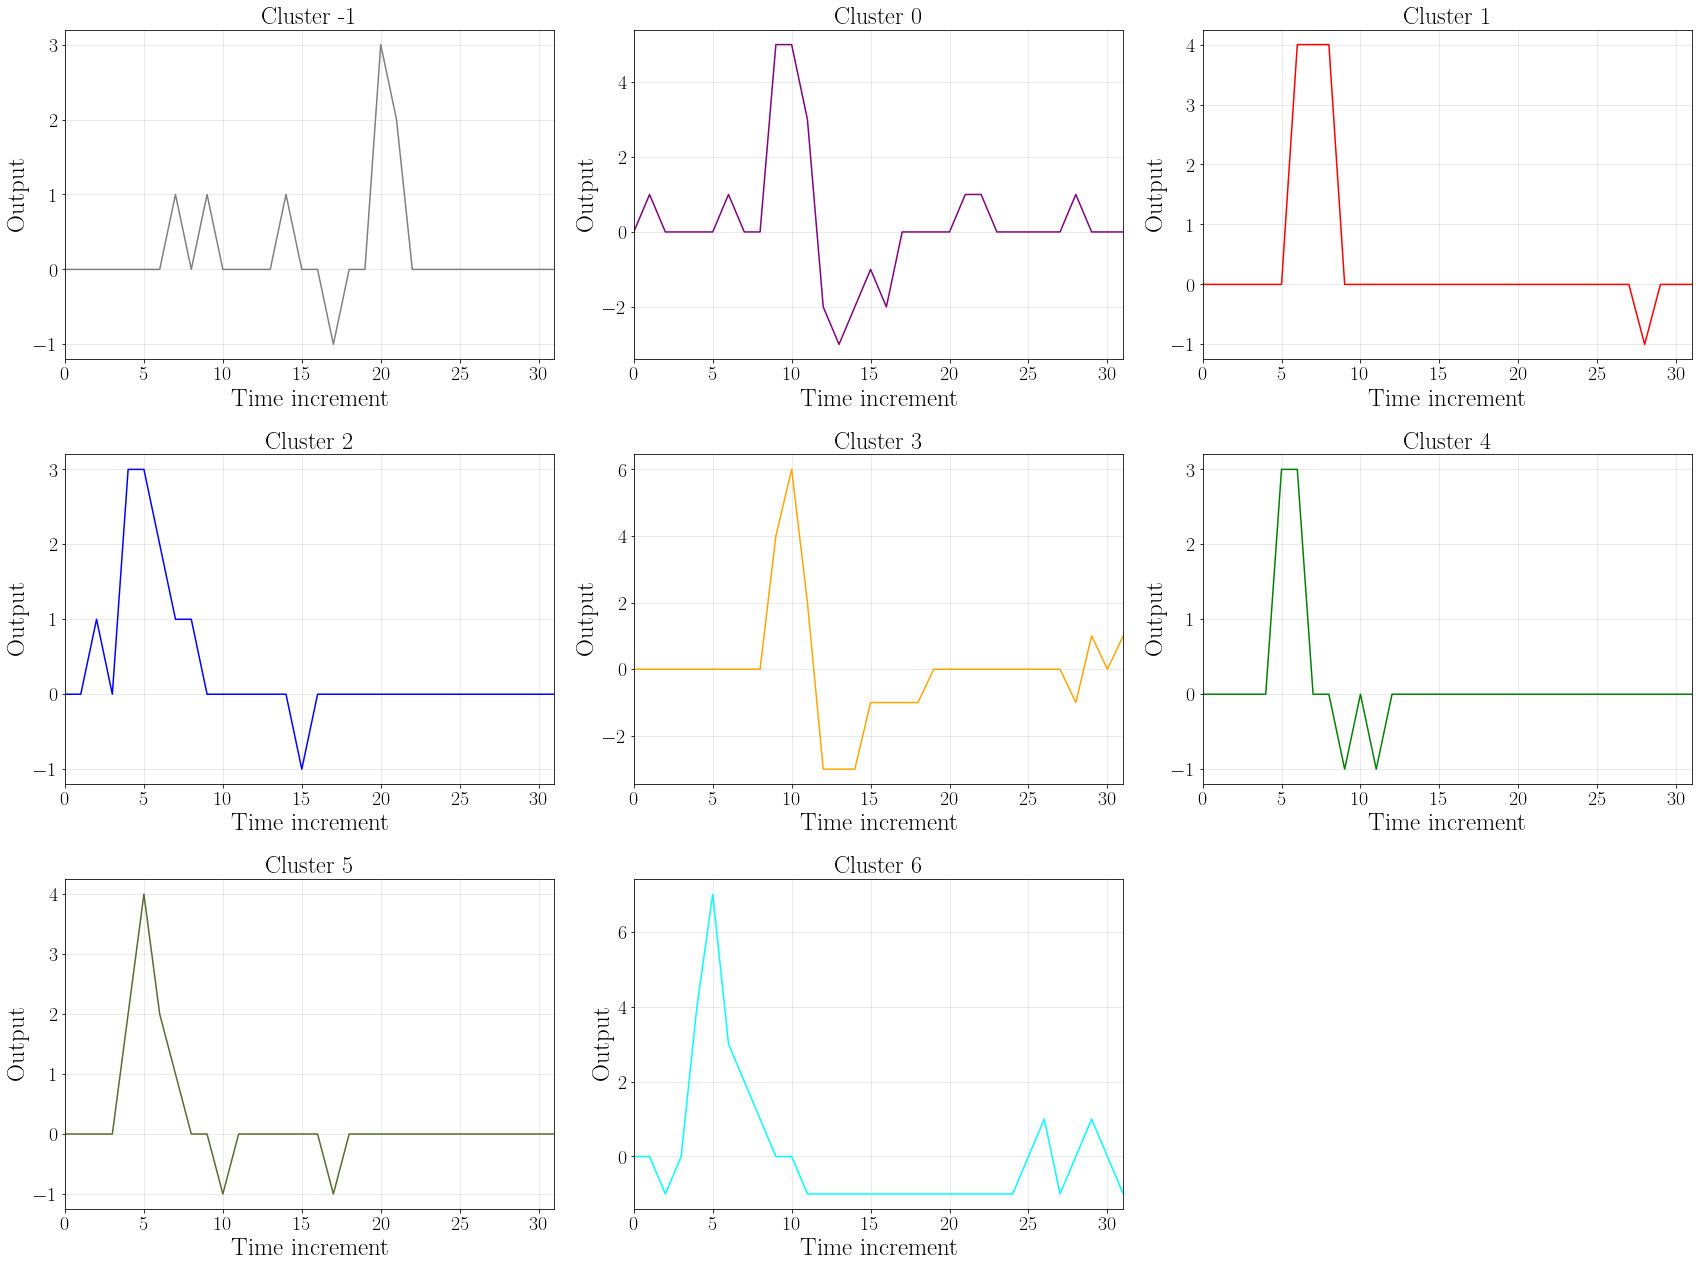

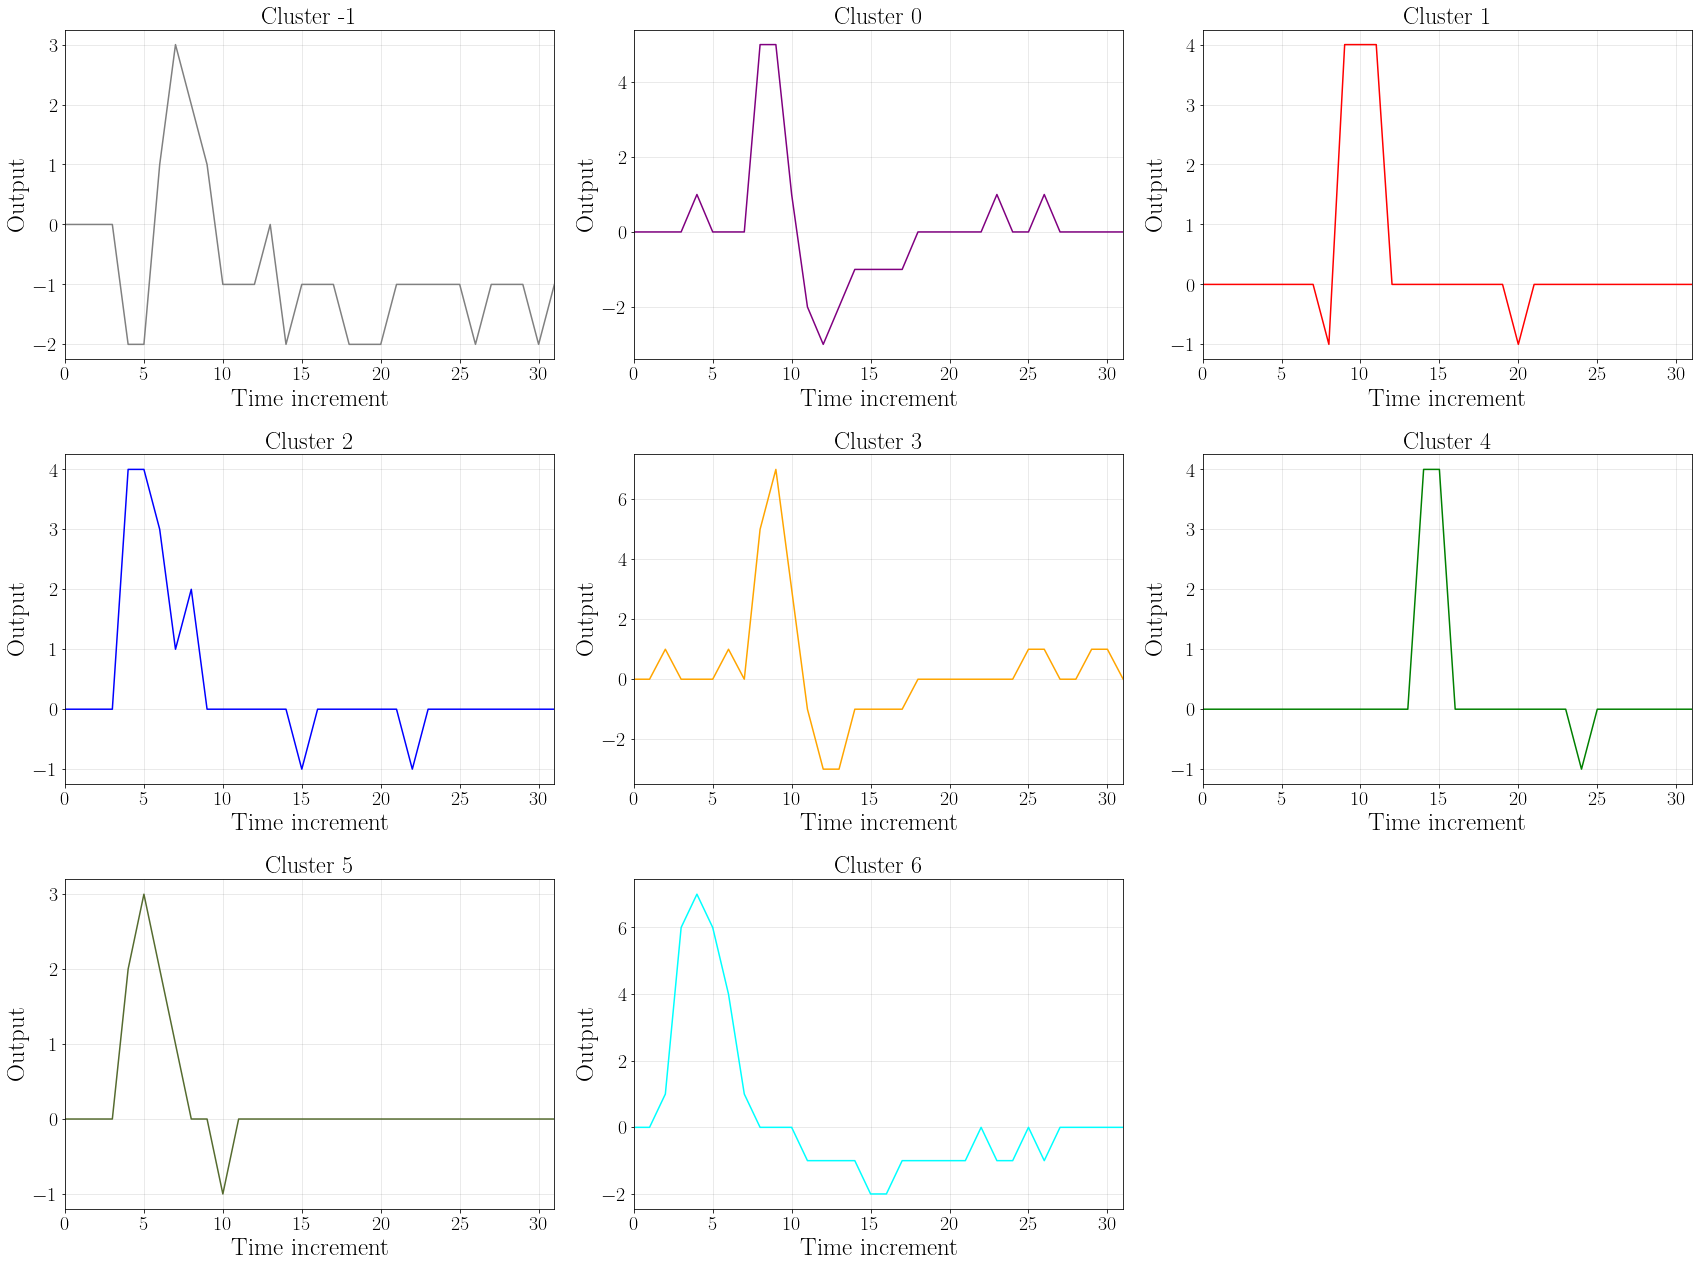

In [131]:
for i in range(5):
    clustering.plot_samples_clusters(
        dataframe_1,
        clu_label_name,
        dict_color_clu_labels=dict_color_clu_labels,
    )